In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp

# OPEN ISSUE ON MAC OSX for TF model training
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from sklearn.metrics import brier_score_loss, accuracy_score, f1_score 
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.model_selection import train_test_split

import aequitas as ae
import functools

# my functions
import functions as fun

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
# from IPython.display import clear_output

In [2]:
%load_ext autoreload
%autoreload

In [3]:
# processed_df = pd.read_csv('processed_df.csv')
# processed_df.head()

In [4]:
# prob_df = pd.read_csv('prob_output_df.csv')
# prob_df.head()

In [5]:
reduced_df = pd.read_csv('reduce_dim_df.csv')
reduced_df.head()

encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital payer_code         medical_specialty  \
0                 1          ?  Pediatrics-Endocrinology   
1                 3          ?                         ?   
2                 2          ?                         ?   
3                 2          ?                         ?   
4                 1          ?                         ?   

  primary_diagnosis_code other_diagnosis_codes  number_outpatient  \
0                 250.83                   ?|?                  0   
1                    276            250.01|255                  0   
2                    648               250|V27                  2   
3                      8            250.43|403                  0   
4                    197               157|250                  0   

   number_inpatient  number_emergency  num_lab_procedures  number_diagnoses  \
0                 0                 0                  41                 1   
1                 0                 0                  59                 9   
2                 1                 0                  11                 6   
3                 0                 0                  44                 7   
4                 0                 0                  51                 5   

   num_medications  num_procedures max_glu_serum A1Cresult change readmitted  \
0                1               0          None      None     No         NO   
1               18               0          None      None     Ch        >30   
2               13               5          None      None     No         NO   
3               16               1          None      None     Ch         NO   
4                8               0          None      None     Ch         NO   

  generic_drug_name  
0               NaN  
1     Human Insulin  
2         Glipizide  
3     Human Insulin  
4         Glipizide

In [6]:
reduced_df.shape

(143482, 26)

In [7]:
reduced_df.dtypes

encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
primary_diagnosis_code      object
other_diagnosis_codes       object
number_outpatient            int64
number_inpatient             int64
number_emergency             int64
num_lab_procedures           int64
number_diagnoses             int64
num_medications              int64
num_procedures               int64
max_glu_serum               object
A1Cresult                   object
change                      object
readmitted                  object
generic_drug_name           object
dtype: object

In [8]:
encounter_df = reduced_df.sort_values(['encounter_id'], 
                              ascending=True).groupby('patient_nbr').head(1)
encounter_df.head()

encounter_id  patient_nbr             race  gender       age weight  \
12         12522     48330783        Caucasian  Female   [80-90)      ?   
14         15738     63555939        Caucasian  Female  [90-100)      ?   
4          16680     42519267        Caucasian    Male   [40-50)      ?   
15         28236     89869032  AfricanAmerican  Female   [40-50)      ?   
6          35754     82637451        Caucasian    Male   [50-60)      ?   

    admission_type_id  discharge_disposition_id  admission_source_id  \
12                  2                         1                    4   
14                  3                         3                    4   
4                   1                         1                    7   
15                  1                         1                    7   
6                   2                         1                    2   

    time_in_hospital payer_code medical_specialty primary_diagnosis_code  \
12                13          ?                 ?                    398   
14                12          ?  InternalMedicine                    434   
4                  1          ?                 ?                    197   
15                 9          ?                 ?                  250.7   
6                  3          ?                 ?                    414   

   other_diagnosis_codes  number_outpatient  number_inpatient  \
12                427|38                  0                 0   
14               198|486                  0                 0   
4                157|250                  0                 0   
15               403|996                  0                 0   
6                411|250                  0                 0   

    number_emergency  num_lab_procedures  number_diagnoses  num_medications  \
12                 0                  68                 8               28   
14                 0                  33                 8               18   
4                  0                  51                 5                8   
15                 0                  47                 9               17   
6                  0                  31                 9               16   

    num_procedures max_glu_serum A1Cresult change readmitted generic_drug_name  
12               2          None      None     Ch         NO     Insulin Human  
14               3          None      None     Ch         NO     Human Insulin  
4                0          None      None     Ch         NO         Glipizide  
15               2          None      None     No        >30     Human Insulin  
6                6          None      None     No        >30     Insulin Human

In [9]:
encounter_df.shape

(71518, 26)

In [10]:
encounter_df.encounter_id.nunique()

71518

In [12]:
unique_patients = encounter_df['patient_nbr'].nunique()
print(f'Unique patients: {unique_patients}')

unique_encounters = encounter_df['encounter_id'].nunique()
print(f'Unique encounters: {unique_encounters}')

original_patient_count = reduced_df['patient_nbr'].nunique()
print(f'Unique patients: {original_patient_count}')

Unique patients: 71518
Unique encounters: 71518
Unique patients: 71518


In [13]:
encounter_df.change.replace({'Ch': 'Yes'}, inplace=True)
encounter_df.change.value_counts(normalize=True)

encounter_df['readmitted_binary'] = encounter_df['readmitted']
encounter_df.readmitted_binary.replace({'>30': 'Yes', '<30': 'Yes'}, 
                                       inplace=True)
encounter_df['readmitted_binary'].value_counts(normalize=True)

second_list = []
third_list = []
for val in encounter_df['other_diagnosis_codes']:
    second_list.append(val.split('|')[0])
    third_list.append(val.split('|')[1])
    
encounter_df['second_diagnosis_code'] = second_list
encounter_df['other_diagnosis_code'] = third_list

encounter_df.drop(['other_diagnosis_codes'], axis=1, inplace=True)

In [15]:
encounter_df.loc[encounter_df['gender']=='Unknown/Invalid']
encounter_df.drop([40924, 105884, 116206], axis=0, inplace=True)

In [16]:
encounter_df.to_csv('encounter_level.csv', index=False)

In [25]:
import pickle

In [29]:
diab_dict = pickle.load(open("diag_codes.pkl", "rb"))

In [30]:
diab_dict[782]

'other'

In [33]:
df_dict = pd.DataFrame(list(diab_dict.items()),columns = ['diag_code','diagnosis'])

In [35]:
df_dict.to_csv('diagnosis_codes.csv', index=False)

In [45]:
groups = [col for col in encounter_df.columns if col != 'generic_drug']

In [46]:
agg_df, agg_drug_cols = fun.aggregate_dataset(df=encounter_df, group_list=groups,
                                         array_field='generic_drug_name')

In [47]:
agg_df

encounter_id  patient_nbr             race  gender       age weight  \
0             12522     48330783        Caucasian  Female   [80-90)      ?   
1             15738     63555939        Caucasian  Female  [90-100)      ?   
2             16680     42519267        Caucasian    Male   [40-50)      ?   
3             28236     89869032  AfricanAmerican  Female   [40-50)      ?   
4             35754     82637451        Caucasian    Male   [50-60)      ?   
...             ...          ...              ...     ...       ...    ...   
54266     443841992    184875899            Other    Male   [40-50)      ?   
54267     443842016    183087545        Caucasian  Female   [70-80)      ?   
54268     443842022    188574944            Other  Female   [40-50)      ?   
54269     443842070    140199494            Other  Female   [60-70)      ?   
54270     443842340    120975314        Caucasian  Female   [80-90)      ?   

       admission_type_id  discharge_disposition_id  admission_source_id  \
0                      2                         1                    4   
1                      3                         3                    4   
2                      1                         1                    7   
3                      1                         1                    7   
4                      2                         1                    2   
...                  ...                       ...                  ...   
54266                  1                         1                    7   
54267                  1                         1                    7   
54268                  1                         1                    7   
54269                  1                         1                    7   
54270                  1                         1                    7   

       time_in_hospital payer_code medical_specialty primary_diagnosis_code  \
0                    13          ?                 ?                    398   
1                    12          ?  InternalMedicine                    434   
2                     1          ?                 ?                    197   
3                     9          ?                 ?                  250.7   
4                     3          ?                 ?                    414   
...                 ...        ...               ...                    ...   
54266                13          ?                 ?                  250.8   
54267                 9          ?                 ?                    574   
54268                14         MD                 ?                    592   
54269                 2         MD                 ?                    996   
54270                 5         MC                 ?                    292   

      other_diagnosis_codes  number_outpatient  number_inpatient  \
0                    427|38                  0                 0   
1                   198|486                  0                 0   
2                   157|250                  0                 0   
3                   403|996                  0                 0   
4                   411|250                  0                 0   
...                     ...                ...               ...   
54266               730|731                  0                 0   
54267            574|250.02                  0                 0   
54268               599|518                  0                 0   
54269               585|403                  1                 1   
54270                 8|304                  0                 0   

       number_emergency  num_lab_procedures  number_diagnoses  \
0                     0                  68                 8   
1                     0                  33                 8   
2                     0                  51                 5   
3                     0                  47                 9   
4                     0                  31                 9   
...          

In [48]:
len(agg_df) == agg_df['patient_nbr'].nunique() == agg_df['encounter_id'].nunique()

True

In [16]:
agg_drug_cols

['Acarbose',
 'Glimepiride',
 'Glipizide',
 'Glipizide_And_Metformin_Hcl',
 'Glipizide_And_Metformin_Hydrochloride',
 'Glyburide',
 'Glyburide_And_Metformin_Hydrochloride',
 'Glyburide-metformin_Hydrochloride',
 'Human_Insulin',
 'Insulin_Human',
 'Metformin_Hcl',
 'Metformin_Hydrochloride',
 'Miglitol',
 'Nateglinide',
 'Pioglitazone',
 'Pioglitazone_Hydrochloride_And_Glimepiride',
 'Repaglinide',
 'Rosiglitazone_Maleate',
 'Tolazamide',
 'Tolbutamide']

In [17]:
agg_df.change.replace({'Ch': 'Yes'}, inplace=True)
agg_df.change.value_counts(normalize=True)

Yes    0.590057
No     0.409943
Name: change, dtype: float64

In [18]:
agg_df['readmitted_binary'] = agg_df['readmitted']
agg_df.readmitted_binary.replace({'>30': 'Yes', '<30': 'Yes'}, inplace=True)
agg_df['readmitted_binary'].value_counts(normalize=True)

NO     0.583479
Yes    0.416521
Name: readmitted_binary, dtype: float64

In [19]:
agg_df.head()

encounter_id  patient_nbr             race  gender       age weight  \
0         12522     48330783        Caucasian  Female   [80-90)      ?   
1         15738     63555939        Caucasian  Female  [90-100)      ?   
2         16680     42519267        Caucasian    Male   [40-50)      ?   
3         28236     89869032  AfricanAmerican  Female   [40-50)      ?   
4         35754     82637451        Caucasian    Male   [50-60)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  2                         1                    4   
1                  3                         3                    4   
2                  1                         1                    7   
3                  1                         1                    7   
4                  2                         1                    2   

   time_in_hospital payer_code medical_specialty primary_diagnosis_code  \
0                13          ?                 ?                    398   
1                12          ?  InternalMedicine                    434   
2                 1          ?                 ?                    197   
3                 9          ?                 ?                  250.7   
4                 3          ?                 ?                    414   

  other_diagnosis_codes  number_outpatient  number_inpatient  \
0                427|38                  0                 0   
1               198|486                  0                 0   
2               157|250                  0                 0   
3               403|996                  0                 0   
4               411|250                  0                 0   

   number_emergency  num_lab_procedures  number_diagnoses  num_medications  \
0                 0                  68                 8               28   
1                 0                  33                 8               18   
2                 0                  51                 5                8   
3                 0                  47                 9               17   
4                 0                  31                 9               16   

   num_procedures max_glu_serum A1Cresult change readmitted generic_drug_name  \
0               2          None      None    Yes         NO     Insulin Human   
1               3          None      None    Yes         NO     Human Insulin   
2               0          None      None    Yes         NO         Glipizide   
3               2          None      None     No        >30     Human Insulin   
4               6          None      None     No        >30     Insulin Human   

  generic_drug_name_array  Acarbose  Glimepiride  Glipizide  \
0         [Insulin Human]         0            0          0   
1         [Human Insulin]         0            0          0   
2             [Glipizide]         0            0          1   
3         [Human Insulin]         0            0          0   
4         [Insulin Human]         0            0          0   

   Glipizide_And_Metformin_Hcl  Glipizide_And_Metformin_Hydrochloride  \
0                            0                                      0   
1                            0                                      0   
2                            0                                      0   
3                            0                                      0   
4                            0                                      0   

   Glyburide  Glyburide_And_Metformin_Hydrochloride  \
0          0                                      0   
1          0                                      0   
2          0                                      0   
3          0                                      0   
4          0                                      0   

   Glyburide-metformin_Hydrochloride  Human_Insulin  Insulin_Human  \
0                                  0              0              1   
1                                  0              

In [20]:
second_list = []
third_list = []
for val in agg_df['other_diagnosis_codes']:
    second_list.append(val.split('|')[0])
    third_list.append(val.split('|')[1])

In [21]:
# third_list

In [22]:
# second_list

In [23]:
agg_df['second_diagnosis_code'] = second_list
agg_df['other_diagnosis_code'] = third_list

In [24]:
agg_df.drop(['other_diagnosis_codes'], axis=1, inplace=True)

In [25]:
agg_df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'primary_diagnosis_code', 'number_outpatient', 'number_inpatient',
       'number_emergency', 'num_lab_procedures', 'number_diagnoses',
       'num_medications', 'num_procedures', 'max_glu_serum', 'A1Cresult',
       'change', 'readmitted', 'generic_drug_name', 'generic_drug_name_array',
       'Acarbose', 'Glimepiride', 'Glipizide', 'Glipizide_And_Metformin_Hcl',
       'Glipizide_And_Metformin_Hydrochloride', 'Glyburide',
       'Glyburide_And_Metformin_Hydrochloride',
       'Glyburide-metformin_Hydrochloride', 'Human_Insulin', 'Insulin_Human',
       'Metformin_Hcl', 'Metformin_Hydrochloride', 'Miglitol', 'Nateglinide',
       'Pioglitazone', 'Pioglitazone_Hydrochloride_And_Glimepiride',
       'Repaglinide', 'Rosiglitazone_Maleate', 'Tolazamide', 'Tolbutamide',
  

In [26]:
agg_df.loc[agg_df['gender']=='Unknown/Invalid']
agg_df.drop([16776, 44911], axis=0, inplace=True)

In [27]:
agg_df.head()

encounter_id  patient_nbr             race  gender       age weight  \
0         12522     48330783        Caucasian  Female   [80-90)      ?   
1         15738     63555939        Caucasian  Female  [90-100)      ?   
2         16680     42519267        Caucasian    Male   [40-50)      ?   
3         28236     89869032  AfricanAmerican  Female   [40-50)      ?   
4         35754     82637451        Caucasian    Male   [50-60)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  2                         1                    4   
1                  3                         3                    4   
2                  1                         1                    7   
3                  1                         1                    7   
4                  2                         1                    2   

   time_in_hospital payer_code medical_specialty primary_diagnosis_code  \
0                13          ?                 ?                    398   
1                12          ?  InternalMedicine                    434   
2                 1          ?                 ?                    197   
3                 9          ?                 ?                  250.7   
4                 3          ?                 ?                    414   

   number_outpatient  number_inpatient  number_emergency  num_lab_procedures  \
0                  0                 0                 0                  68   
1                  0                 0                 0                  33   
2                  0                 0                 0                  51   
3                  0                 0                 0                  47   
4                  0                 0                 0                  31   

   number_diagnoses  num_medications  num_procedures max_glu_serum A1Cresult  \
0                 8               28               2          None      None   
1                 8               18               3          None      None   
2                 5                8               0          None      None   
3                 9               17               2          None      None   
4                 9               16               6          None      None   

  change readmitted generic_drug_name generic_drug_name_array  Acarbose  \
0    Yes         NO     Insulin Human         [Insulin Human]         0   
1    Yes         NO     Human Insulin         [Human Insulin]         0   
2    Yes         NO         Glipizide             [Glipizide]         0   
3     No        >30     Human Insulin         [Human Insulin]         0   
4     No        >30     Insulin Human         [Insulin Human]         0   

   Glimepiride  Glipizide  Glipizide_And_Metformin_Hcl  \
0            0          0                            0   
1            0          0                            0   
2            0          1                            0   
3            0          0                            0   
4            0          0                            0   

   Glipizide_And_Metformin_Hydrochloride  Glyburide  \
0                                      0          0   
1                                      0          0   
2                                      0          0   
3                                      0          0   
4                                      0          0   

   Glyburide_And_Metformin_Hydrochloride  Glyburide-metformin_Hydrochloride  \
0                                      0                                  0   
1                                      0                                  0   
2                                      0                                  0   
3                                      0                                  0   
4                                      0                                  0   

   Human_Insulin  Insulin_Human  Metformin_Hcl  Metformin_Hydrochloride  \
0              0              1      

In [28]:
num_cols = agg_df.select_dtypes(exclude='O')
cat_cols = agg_df.select_dtypes(include='O')

In [29]:
num_cols.drop(['patient_nbr', 'encounter_id', 'Acarbose', 'Glimepiride', 'Glipizide',
       'Glipizide_And_Metformin_Hcl', 'Glipizide_And_Metformin_Hydrochloride',
       'Glyburide', 'Glyburide_And_Metformin_Hydrochloride',
       'Glyburide-metformin_Hydrochloride', 'Human_Insulin', 'Insulin_Human',
       'Metformin_Hcl', 'Metformin_Hydrochloride', 'Miglitol', 'Nateglinide',
       'Pioglitazone', 'Pioglitazone_Hydrochloride_And_Glimepiride',
       'Repaglinide', 'Rosiglitazone_Maleate', 'Tolazamide', 'Tolbutamide'],axis=1,
              inplace=True)

In [30]:
num_cols.columns

Index(['admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'number_outpatient', 'number_inpatient',
       'number_emergency', 'num_lab_procedures', 'number_diagnoses',
       'num_medications', 'num_procedures'],
      dtype='object')

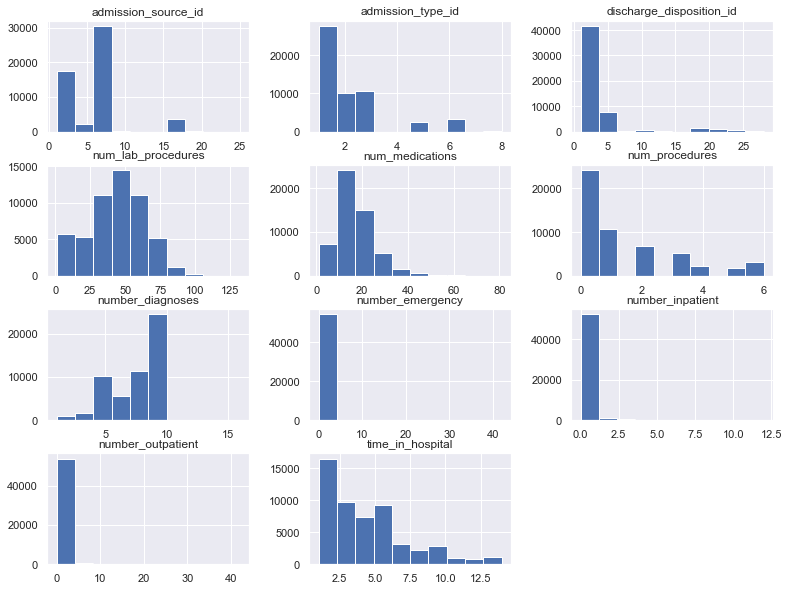

In [31]:
num_cols.hist(figsize = (13, 10))
plt.show()

In [32]:
agg_df.head()

encounter_id  patient_nbr             race  gender       age weight  \
0         12522     48330783        Caucasian  Female   [80-90)      ?   
1         15738     63555939        Caucasian  Female  [90-100)      ?   
2         16680     42519267        Caucasian    Male   [40-50)      ?   
3         28236     89869032  AfricanAmerican  Female   [40-50)      ?   
4         35754     82637451        Caucasian    Male   [50-60)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  2                         1                    4   
1                  3                         3                    4   
2                  1                         1                    7   
3                  1                         1                    7   
4                  2                         1                    2   

   time_in_hospital payer_code medical_specialty primary_diagnosis_code  \
0                13          ?                 ?                    398   
1                12          ?  InternalMedicine                    434   
2                 1          ?                 ?                    197   
3                 9          ?                 ?                  250.7   
4                 3          ?                 ?                    414   

   number_outpatient  number_inpatient  number_emergency  num_lab_procedures  \
0                  0                 0                 0                  68   
1                  0                 0                 0                  33   
2                  0                 0                 0                  51   
3                  0                 0                 0                  47   
4                  0                 0                 0                  31   

   number_diagnoses  num_medications  num_procedures max_glu_serum A1Cresult  \
0                 8               28               2          None      None   
1                 8               18               3          None      None   
2                 5                8               0          None      None   
3                 9               17               2          None      None   
4                 9               16               6          None      None   

  change readmitted generic_drug_name generic_drug_name_array  Acarbose  \
0    Yes         NO     Insulin Human         [Insulin Human]         0   
1    Yes         NO     Human Insulin         [Human Insulin]         0   
2    Yes         NO         Glipizide             [Glipizide]         0   
3     No        >30     Human Insulin         [Human Insulin]         0   
4     No        >30     Insulin Human         [Insulin Human]         0   

   Glimepiride  Glipizide  Glipizide_And_Metformin_Hcl  \
0            0          0                            0   
1            0          0                            0   
2            0          1                            0   
3            0          0                            0   
4            0          0                            0   

   Glipizide_And_Metformin_Hydrochloride  Glyburide  \
0                                      0          0   
1                                      0          0   
2                                      0          0   
3                                      0          0   
4                                      0          0   

   Glyburide_And_Metformin_Hydrochloride  Glyburide-metformin_Hydrochloride  \
0                                      0                                  0   
1                                      0                                  0   
2                                      0                                  0   
3                                      0                                  0   
4                                      0                                  0   

   Human_Insulin  Insulin_Human  Metformin_Hcl  Metformin_Hydrochloride  \
0              0              1      

In [33]:
agg_df.to_csv('aggregated.csv', index=False)

In [32]:
num_feats = ['num_lab_procedures', 'num_medications', 'time_in_hospital']
cat_feats = ['race', 'gender', 'age', 'primary_diagnosis_code', 
             'second_diagnosis_code', 'other_diagnosis_code', 
                                                    'change'] + agg_drug_cols
TARGET = 'readmitted_binary'

In [33]:
feats_df = fun.select_features(agg_df, cat_feats, num_feats, TARGET)
feats_df

patient_nbr readmitted_binary             race  gender       age  \
0         48330783                NO        Caucasian  Female   [80-90)   
1         63555939                NO        Caucasian  Female  [90-100)   
2         42519267                NO        Caucasian    Male   [40-50)   
3         89869032               Yes  AfricanAmerican  Female   [40-50)   
4         82637451               Yes        Caucasian    Male   [50-60)   
...            ...               ...              ...     ...       ...   
54266    184875899                NO            Other    Male   [40-50)   
54267    183087545               Yes        Caucasian  Female   [70-80)   
54268    188574944               Yes            Other  Female   [40-50)   
54269    140199494               Yes            Other  Female   [60-70)   
54270    120975314                NO        Caucasian  Female   [80-90)   

      primary_diagnosis_code second_diagnosis_code other_diagnosis_code  \
0                        398                   427                   38   
1                        434                   198                  486   
2                        197                   157                  250   
3                      250.7                   403                  996   
4                        414                   411                  250   
...                      ...                   ...                  ...   
54266                  250.8                   730                  731   
54267                    574                   574               250.02   
54268                    592                   599                  518   
54269                    996                   585                  403   
54270                    292                     8                  304   

      change  Acarbose  Glimepiride  Glipizide  Glipizide_And_Metformin_Hcl  \
0        Yes         0            0          0                            0   
1        Yes         0            0          0                            0   
2        Yes         0            0          1                            0   
3         No         0            0          0                            0   
4         No         0            0          0                            0   
...      ...       ...          ...        ...                          ...   
54266    Yes         0            0          0                            0   
54267    Yes         0            0          0                            0   
54268    Yes         0            0          1                            0   
54269     No         0            0          0                            0   
54270    Yes         0            0          0                            0   

       Glipizide_And_Metformin_Hydrochloride  Glyburide  \
0                                          0          0   
1                                          0          0   
2                                          0          0   
3                                          0          0   
4                                          0          0   
...                                      ...        ...   
54266                                      0          0   
54267                                      0          1   
54268                                      0          0   
54269                                      0          0   
54270                                      0          0   

       Glyburide_And_Metformin_Hydrochloride  \
0                                          0   
1                                          0   
2                                          0   
3                                          0   
4                                          0   
...                                      ...   
54266                                      0   
54267                                      0   
54268                                      0   
54269                                      0   
54270              

In [34]:
feats_df['readmitted_binary'].replace({'NO': 0, 'Yes': 1}, inplace=True)

In [35]:
feats_df

patient_nbr  readmitted_binary             race  gender       age  \
0         48330783                  0        Caucasian  Female   [80-90)   
1         63555939                  0        Caucasian  Female  [90-100)   
2         42519267                  0        Caucasian    Male   [40-50)   
3         89869032                  1  AfricanAmerican  Female   [40-50)   
4         82637451                  1        Caucasian    Male   [50-60)   
...            ...                ...              ...     ...       ...   
54266    184875899                  0            Other    Male   [40-50)   
54267    183087545                  1        Caucasian  Female   [70-80)   
54268    188574944                  1            Other  Female   [40-50)   
54269    140199494                  1            Other  Female   [60-70)   
54270    120975314                  0        Caucasian  Female   [80-90)   

      primary_diagnosis_code second_diagnosis_code other_diagnosis_code  \
0                        398                   427                   38   
1                        434                   198                  486   
2                        197                   157                  250   
3                      250.7                   403                  996   
4                        414                   411                  250   
...                      ...                   ...                  ...   
54266                  250.8                   730                  731   
54267                    574                   574               250.02   
54268                    592                   599                  518   
54269                    996                   585                  403   
54270                    292                     8                  304   

      change  Acarbose  Glimepiride  Glipizide  Glipizide_And_Metformin_Hcl  \
0        Yes         0            0          0                            0   
1        Yes         0            0          0                            0   
2        Yes         0            0          1                            0   
3         No         0            0          0                            0   
4         No         0            0          0                            0   
...      ...       ...          ...        ...                          ...   
54266    Yes         0            0          0                            0   
54267    Yes         0            0          0                            0   
54268    Yes         0            0          1                            0   
54269     No         0            0          0                            0   
54270    Yes         0            0          0                            0   

       Glipizide_And_Metformin_Hydrochloride  Glyburide  \
0                                          0          0   
1                                          0          0   
2                                          0          0   
3                                          0          0   
4                                          0          0   
...                                      ...        ...   
54266                                      0          0   
54267                                      0          1   
54268                                      0          0   
54269                                      0          0   
54270                                      0          0   

       Glyburide_And_Metformin_Hydrochloride  \
0                                          0   
1                                          0   
2                                          0   
3                                          0   
4                                          0   
...                                      ...   
54266                                      0   
54267                                      0   
54268                                      0   
54269                                      0   
54270  

In [36]:
def update_dtypes(df, categorical_col_list, predictor):
    df[predictor] = df[predictor].astype(float)
    for col in categorical_col_list:
        df[col] = df[col].astype('str')
    return df

In [37]:
feats_df.dtypes

patient_nbr                                    int64
readmitted_binary                              int64
race                                          object
gender                                        object
age                                           object
primary_diagnosis_code                        object
second_diagnosis_code                         object
other_diagnosis_code                          object
change                                        object
Acarbose                                       uint8
Glimepiride                                    uint8
Glipizide                                      uint8
Glipizide_And_Metformin_Hcl                    uint8
Glipizide_And_Metformin_Hydrochloride          uint8
Glyburide                                      uint8
Glyburide_And_Metformin_Hydrochloride          uint8
Glyburide-metformin_Hydrochloride              uint8
Human_Insulin                                  uint8
Insulin_Human                                 

In [38]:
processed_df = update_dtypes(feats_df, cat_feats, TARGET)

In [39]:
processed_df.columns

Index(['patient_nbr', 'readmitted_binary', 'race', 'gender', 'age',
       'primary_diagnosis_code', 'second_diagnosis_code',
       'other_diagnosis_code', 'change', 'Acarbose', 'Glimepiride',
       'Glipizide', 'Glipizide_And_Metformin_Hcl',
       'Glipizide_And_Metformin_Hydrochloride', 'Glyburide',
       'Glyburide_And_Metformin_Hydrochloride',
       'Glyburide-metformin_Hydrochloride', 'Human_Insulin', 'Insulin_Human',
       'Metformin_Hcl', 'Metformin_Hydrochloride', 'Miglitol', 'Nateglinide',
       'Pioglitazone', 'Pioglitazone_Hydrochloride_And_Glimepiride',
       'Repaglinide', 'Rosiglitazone_Maleate', 'Tolazamide', 'Tolbutamide',
       'num_lab_procedures', 'num_medications', 'time_in_hospital'],
      dtype='object')

In [40]:
processed_df.dtypes

patient_nbr                                     int64
readmitted_binary                             float64
race                                           object
gender                                         object
age                                            object
primary_diagnosis_code                         object
second_diagnosis_code                          object
other_diagnosis_code                           object
change                                         object
Acarbose                                       object
Glimepiride                                    object
Glipizide                                      object
Glipizide_And_Metformin_Hcl                    object
Glipizide_And_Metformin_Hydrochloride          object
Glyburide                                      object
Glyburide_And_Metformin_Hydrochloride          object
Glyburide-metformin_Hydrochloride              object
Human_Insulin                                  object
Insulin_Human               

In [41]:
# processed_df.to_csv('processed_for_modeling.csv', index=False)

In [42]:
train, test = train_test_split(processed_df, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

34732 train examples
8683 validation examples
10854 test examples


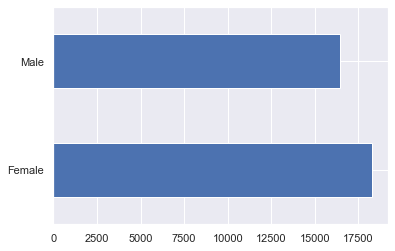

In [43]:
train.gender.value_counts().plot(kind='barh')
plt.show()

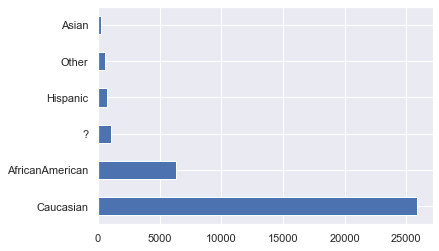

In [44]:
train['race'].value_counts().plot(kind='barh')
plt.show()

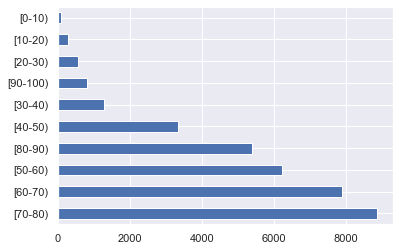

In [45]:
train['age'].value_counts().plot(kind='barh')
plt.show()

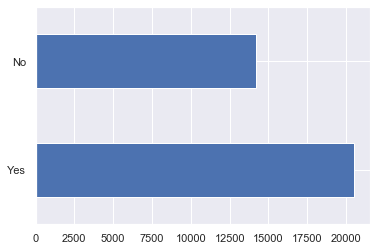

In [46]:
train['change'].value_counts().plot(kind='barh')
plt.show()

In [47]:
# processed_df['target'] = np.where(feats_df['readmitted_binary']==1, 0, 1)

readmitted_binary
0.0    31664
1.0    22605
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


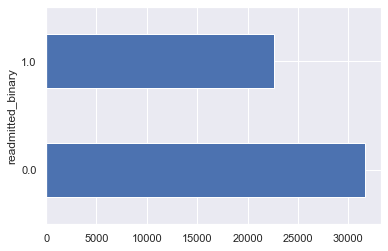

In [48]:
fun.demo_plots(feats_df, TARGET)

readmitted_binary
0.0    20292
1.0    14440
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


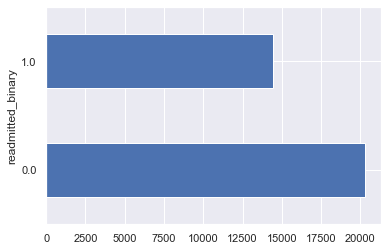

In [49]:
fun.demo_plots(train, TARGET)

readmitted_binary
0.0    6353
1.0    4501
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


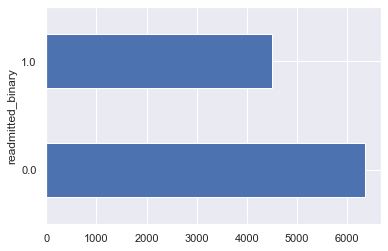

In [50]:
fun.demo_plots(test, TARGET)

readmitted_binary
0.0    5019
1.0    3664
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


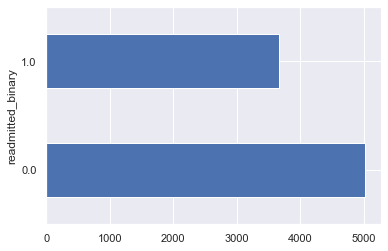

In [51]:
fun.demo_plots(val, TARGET)

readmitted_binary
0.0    5019
1.0    3664
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


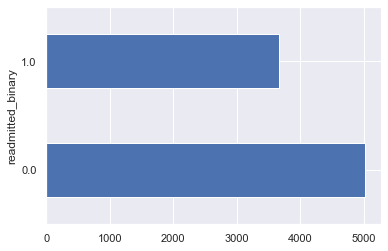

In [52]:
fun.demo_plots(val, TARGET)

# TENSORFLOW:

In [55]:
# Create a sequential model
model = tf.keras.Sequential()

# Add a dense layer 
model.add(tf.keras.layers.Dense(1, input_shape=(4,), activation='sigmoid'))

# Compile your model
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

# Display a summary of your model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 5         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


In [75]:
# Train your model for 20 epochs
model.fit(X_train, y_train, epochs = 20)

# Evaluate your model accuracy on the test set
accuracy = model.evaluate(X_test, y_test)[1]

# Print accuracy
print('Accuracy:', accuracy)

Epoch 1/20


ValueError: in user code:

    /Users/leighannahooper/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /Users/leighannahooper/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/leighannahooper/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/leighannahooper/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/leighannahooper/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/leighannahooper/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /Users/leighannahooper/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /Users/leighannahooper/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /Users/leighannahooper/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:259 assert_input_compatibility
        ' but received input with shape ' + display_shape(x.shape))

    ValueError: Input 0 of layer sequential_1 is incompatible with the layer: expected axis -1 of input shape to have value 4 but received input with shape (None, 42)


In [53]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe[TARGET]
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds

In [54]:
# The `lambda:` creates a callable object with no arguments.
batch_size = len(train)
train_ds = lambda: df_to_dataset(train, batch_size=batch_size)
val_ds = lambda: df_to_dataset(val, batch_size=batch_size)
test_ds = lambda: df_to_dataset(test, batch_size=batch_size)

In [56]:
categorical_features = ['race', 'gender', 'age',
       'primary_diagnosis_code', 'second_diagnosis_code',
       'other_diagnosis_code', 'change', 'Acarbose', 'Glimepiride',
       'Glipizide', 'Glipizide_And_Metformin_Hcl',
       'Glipizide_And_Metformin_Hydrochloride', 'Glyburide',
       'Glyburide_And_Metformin_Hydrochloride',
       'Glyburide-metformin_Hydrochloride', 'Human_Insulin', 'Insulin_Human',
       'Metformin_Hcl', 'Metformin_Hydrochloride', 'Miglitol', 'Nateglinide',
       'Pioglitazone', 'Pioglitazone_Hydrochloride_And_Glimepiride',
       'Repaglinide', 'Rosiglitazone_Maleate', 'Tolazamide', 'Tolbutamide']

numerical_features = ['num_lab_procedures', 'num_medications', 
                             'time_in_hospital']

In [57]:
categorical_vocab_list = fun.build_vocab_list(train, categorical_features)
categorical_vocab_list

['./diabetes_vocab/race_vocab.txt',
 './diabetes_vocab/gender_vocab.txt',
 './diabetes_vocab/age_vocab.txt',
 './diabetes_vocab/primary_diagnosis_code_vocab.txt',
 './diabetes_vocab/second_diagnosis_code_vocab.txt',
 './diabetes_vocab/other_diagnosis_code_vocab.txt',
 './diabetes_vocab/change_vocab.txt',
 './diabetes_vocab/Acarbose_vocab.txt',
 './diabetes_vocab/Glimepiride_vocab.txt',
 './diabetes_vocab/Glipizide_vocab.txt',
 './diabetes_vocab/Glipizide_And_Metformin_Hcl_vocab.txt',
 './diabetes_vocab/Glipizide_And_Metformin_Hydrochloride_vocab.txt',
 './diabetes_vocab/Glyburide_vocab.txt',
 './diabetes_vocab/Glyburide_And_Metformin_Hydrochloride_vocab.txt',
 './diabetes_vocab/Glyburide-metformin_Hydrochloride_vocab.txt',
 './diabetes_vocab/Human_Insulin_vocab.txt',
 './diabetes_vocab/Insulin_Human_vocab.txt',
 './diabetes_vocab/Metformin_Hcl_vocab.txt',
 './diabetes_vocab/Metformin_Hydrochloride_vocab.txt',
 './diabetes_vocab/Miglitol_vocab.txt',
 './diabetes_vocab/Nateglinide_vocab.

In [58]:
def create_tf_categorical_feature_cols(categorical_col_list,
                              vocab_dir='./diabetes_vocab/'):

    output_tf_list = []
    for c in categorical_col_list:
        vocab_file_path = os.path.join(vocab_dir,  c + "_vocab.txt")

        tf_categorical_feature_column = tf.feature_column.categorical_column_with_vocabulary_file(
            key=c, vocabulary_file = vocab_file_path, num_oov_buckets=1)
        
        tf_categorical_feature_column = tf.feature_column.indicator_column(tf_categorical_feature_column)
        output_tf_list.append(tf_categorical_feature_column)
    return output_tf_list

In [59]:
tf_categorical_list = create_tf_categorical_feature_cols(categorical_features)

INFO:tensorflow:vocabulary_size = 7 in race is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/race_vocab.txt.
INFO:tensorflow:vocabulary_size = 3 in gender is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/gender_vocab.txt.
INFO:tensorflow:vocabulary_size = 11 in age is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/age_vocab.txt.
INFO:tensorflow:vocabulary_size = 618 in primary_diagnosis_code is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/primary_diagnosis_code_vocab.txt.
INFO:tensorflow:vocabulary_size = 632 in second_diagnosis_code is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/second_diagnosis_code_vocab.txt.
INFO:tensorflow:vocabulary_size = 661 in other_diagnosis_code is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/other_diagnosis_code_vocab.txt.
INFO:tensorflow:vocabulary_size = 3 in change is 

In [60]:
tf_numerical_list = fun.create_tf_numerical_feat_columns(numerical_features, 
                                                         train)

### num_lab_procedures: #mean/std: 43.6149660255672/20.187476059372646, numeric (normalized)
### num_medications: #mean/std: 16.592825060462975/8.490989847083023, numeric (normalized)
### time_in_hospital: #mean/std: 4.4167914315328805/2.9935123541165165, numeric (normalized)


In [61]:
combined_feature_cols = tf_categorical_list + tf_numerical_list
combined_feature_layer = tf.keras.layers.DenseFeatures(combined_feature_cols)

In [62]:
linear_est = tf.estimator.LinearClassifier(combined_feature_cols)

# Train model.
linear_est.train(train_ds, max_steps=100)

# Evaluation.
result = linear_est.evaluate(test_ds)
clear_output()
print(pd.Series(result))

accuracy                0.583840
accuracy_baseline       0.583840
auc                     0.531625
auc_precision_recall    0.435870
average_loss            0.742277
label/mean              0.416160
loss                    0.742277
precision               0.000000
prediction/mean         0.252199
recall                  0.000000
global_step             1.000000
dtype: float64


In [63]:
n_batches = 2
est = tf.estimator.BoostedTreesClassifier(combined_feature_cols,
                                          n_batches_per_layer=n_batches)


est.train(train_ds, max_steps=100)


result = est.evaluate(test_ds)
clear_output()
print(pd.Series(result))

accuracy                0.583840
accuracy_baseline       0.583840
auc                     0.500000
auc_precision_recall    0.708080
average_loss            0.693146
label/mean              0.416160
loss                    0.693146
precision               0.000000
prediction/mean         0.500000
recall                  0.000000
global_step             0.000000
dtype: float64


In [36]:
# pred_dicts = list(est.predict(test_ds))
# probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

# probs.plot(kind='hist', bins=20, title='predicted probabilities')
# plt.show()


In [37]:
# fpr, tpr, _ = roc_curve(test[TARGET], probs)
# plt.plot(fpr, tpr)
# plt.title('ROC curve')
# plt.xlabel('false positive rate')
# plt.ylabel('true positive rate')
# plt.xlim(0,)
# plt.ylim(0,)
# plt.show()

# SUPERVISED MODELING:

In [57]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import recall_score, f1_score, accuracy_score
from sklearn.metrics import precision_score, make_scorer
from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
 
from sklearn.model_selection import KFold, RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score, StratifiedKFold
# from catboost import CatBoostRegressor, CatBoostClassifier

In [58]:
feats_df.race.replace({'?':'Other'}, inplace=True)

In [59]:
X = feats_df.drop(['readmitted_binary'], axis=1)
y = feats_df['readmitted_binary']
X_train, X_test, y_train, y_test = train_test_split(X ,y, test_size=0.2,
                                                    random_state=42)

In [60]:
X_train.shape[0], X_test.shape[0]

(43415, 10854)

In [61]:
y_train.shape[0], y_test.shape[0]

(43415, 10854)

In [62]:
y_train

50619    0.0
42610    0.0
1829     0.0
16358    0.0
28589    0.0
        ... 
11284    0.0
44733    0.0
38159    0.0
860      1.0
15795    0.0
Name: readmitted_binary, Length: 43415, dtype: float64

In [63]:
X_train.drop(['patient_nbr'], axis=1, inplace=True) 
X_train[agg_drug_cols] = X_train[agg_drug_cols].astype('int')

X_test.drop(['patient_nbr'], axis=1, inplace=True) 
X_test[agg_drug_cols] = X_test[agg_drug_cols].astype('int')

In [64]:
X_train.age.replace({'[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35, 
                '[40-50)': 45, '[50-60)': 55,
       '[60-70)': 65, '[70-80)': 75, '[80-90)': 85, '[90-100)': 95}, 
               inplace=True)
X_test.age.replace({'[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35, 
                '[40-50)': 45, '[50-60)': 55,
       '[60-70)': 65, '[70-80)': 75, '[80-90)': 85, '[90-100)': 95}, 
               inplace=True)

# GROUP THESE DIAGNOSES CODES!!

In [62]:
#  'primary_diagnosis_code', 'second_diagnosis_code',
#        'other_diagnosis_code',

In [65]:
categorical_features = ['race', 'gender', 'age',
       'change']

numerical_features =  ['Acarbose',
       'Glimepiride', 'Glipizide', 'Glipizide_And_Metformin_Hcl',
       'Glipizide_And_Metformin_Hydrochloride', 'Glyburide',
       'Glyburide_And_Metformin_Hydrochloride',
       'Glyburide-metformin_Hydrochloride', 'Human_Insulin', 'Insulin_Human',
       'Metformin_Hcl', 'Metformin_Hydrochloride', 'Miglitol', 'Nateglinide',
       'Pioglitazone', 'Pioglitazone_Hydrochloride_And_Glimepiride',
       'Repaglinide', 'Rosiglitazone_Maleate', 'Tolazamide', 'Tolbutamide',
       'num_lab_procedures', 'num_medications', 'time_in_hospital']

In [66]:
num_pipe = Pipeline([
    ('scaler', 
    StandardScaler())])

In [67]:
cat_pipe = Pipeline([
    ('encoder',
        OneHotEncoder(sparse=False))])

In [68]:
preprocessing = ColumnTransformer(transformers=[
    ('num', num_pipe, numerical_features),
    ('cat', cat_pipe, categorical_features)])
preprocessing

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['Acarbose', 'Glimepiride', 'Glipizide',
                                  'Glipizide_And_Metformin_Hcl',
                                  'Glipizide_And_Metformin_Hydrochloride',
                                  'Glyburide',
                                  'Glyburide_And_Metformin_Hydrochloride',
                                  'Glyburide-metformin_Hydrochloride',
                                  'Human_Insulin', 'Insulin_Human',
                                  'Metformin_Hcl', 'Metformin_Hydrochloride',
                                  'Miglitol', 'Nateglinide', 'Pioglitazone',
                                  'Pioglitazone_Hydrochloride_And_Glimepiride',
                                  'Repaglinide', 'Rosiglitazone_Maleate',
                                  'Tolazamide', 'Tolbutamide',
                                

In [69]:
X_train_trans = preprocessing.fit_transform(X_train)
X_test_trans = preprocessing.transform(X_test)

In [70]:
feature_names = preprocessing.named_transformers_['cat'].\
                named_steps['encoder'].get_feature_names(categorical_features).tolist()
# feature_names

In [71]:
# num_cols = num_cols.tolist()
# num_cols

In [72]:
X_cols = numerical_features + feature_names

In [73]:
X_train = pd.DataFrame(X_train_trans,columns=X_cols)
X_test = pd.DataFrame(X_test_trans,columns=X_cols)
X_train.head()

Acarbose  Glimepiride  Glipizide  Glipizide_And_Metformin_Hcl  \
0 -0.031487    -0.214989  -0.351328                    -0.004799   
1 -0.031487    -0.214989  -0.351328                    -0.004799   
2 -0.031487    -0.214989  -0.351328                    -0.004799   
3 -0.031487    -0.214989  -0.351328                    -0.004799   
4 -0.031487    -0.214989  -0.351328                    -0.004799   

   Glipizide_And_Metformin_Hydrochloride  Glyburide  \
0                              -0.006787  -0.304099   
1                              -0.006787  -0.304099   
2                              -0.006787  -0.304099   
3                              -0.006787  -0.304099   
4                              -0.006787  -0.304099   

   Glyburide_And_Metformin_Hydrochloride  Glyburide-metformin_Hydrochloride  \
0                              -0.060052                            -0.0612   
1                              -0.060052                            -0.0612   
2                              -0.060052                            -0.0612   
3                              -0.060052                            -0.0612   
4                              -0.060052                            -0.0612   

   Human_Insulin  Insulin_Human  Metformin_Hcl  Metformin_Hydrochloride  \
0       2.267319      -0.599709      -0.043234                -0.538055   
1      -0.441050      -0.599709      -0.043234                 1.858545   
2      -0.441050      -0.599709      -0.043234                 1.858545   
3      -0.441050      -0.599709      -0.043234                -0.538055   
4      -0.441050      -0.599709      -0.043234                -0.538055   

   Miglitol  Nateglinide  Pioglitazone  \
0 -0.010732    -0.075489     -0.214461   
1 -0.010732    -0.075489     -0.214461   
2 -0.010732    -0.075489     -0.214461   
3 -0.010732    -0.075489     -0.214461   
4 -0.010732    -0.075489     -0.214461   

   Pioglitazone_Hydrochloride_And_Glimepiride  Repaglinide  \
0                                   -0.019792    -0.106621   
1                                   -0.019792    -0.106621   
2                                   -0.019792    -0.106621   
3                                   -0.019792    -0.106621   
4                                   -0.019792    -0.106621   

   Rosiglitazone_Maleate  Tolazamide  Tolbutamide  num_lab_procedures  \
0              -0.196308   -0.019201     -0.01796            0.515742   
1              -0.196308   -0.019201     -0.01796           -0.576841   
2              -0.196308   -0.019201     -0.01796            1.111697   
3               5.094026   -0.019201     -0.01796            1.161360   
4               5.094026   -0.019201     -0.01796            0.565405   

   num_medications  time_in_hospital  race_AfricanAmerican  race_Asian  \
0        -0.422196         -0.136151                   0.0         0.0   
1         0.756999          0.199529                   0.0         0.0   
2        -0.658035         -0.471831                   0.0         0.0   
3         2.172033          0.870889                   0.0         0.0   
4        -0.186357          0.199529                   0.0         0.0   

   race_Caucasian  race_Hispanic  race_Other  gender_Female  gender_Male  \
0             1.0            0.0         0.0            1.0          0.0   
1             1.0            0.0         0.0            1.0          0.0   
2             1.0            0.0         0.0            1.0          0.0   
3             1.0            0.0         0.0            0.0          1.0   
4             1.0            0.0         0.0            1.0          0.0   

   age_5  age_15  age_25  age_35  age_45  age_55  age_65  age_75  age_85  \
0    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     1.0   
1    0.0     0.0     0.0     0.0     0.0     0.0     0.0     1.0     0.0   
2    0.0     0.0     0.0     0.0     0.0     0.0     0.0     1.0     0.0   
3    0.0     0.0     0.0     0.0     0.0     0.0     0.0     1.0  

In [74]:
# X_train.describe().transpose()

In [71]:
# X_train.to_csv('X_train.csv', index=False)
# X_test.to_csv('X_test.csv', index=False)
# y_train.to_csv('y_train.csv', index=False)
# y_train.to_csv('y_train.csv', index=False)

In [225]:
# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train,y_train)

#
y_pred=logreg.predict(X_test)

In [227]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[5954,  403],
       [4105,  392]])

Text(0.5, 257.44, 'Predicted label')

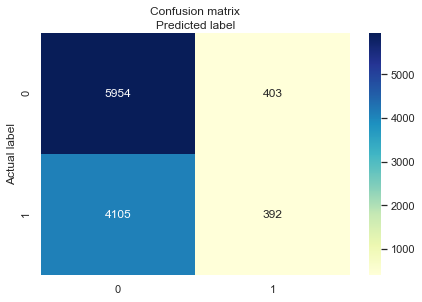

In [228]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [229]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))


Accuracy: 0.5846692463607887
Precision: 0.4930817610062893
Recall: 0.08716922392706249


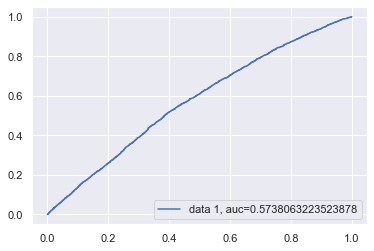

In [230]:
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()


# CATBOOST:

In [119]:
from catboost import CatBoostRegressor, CatBoostClassifier

In [125]:
X = feats_df.drop(['readmitted_binary'], axis=1)
y = feats_df['readmitted_binary']
X_train, X_test, y_train, y_test = train_test_split(X ,y, test_size=0.2,
                                                    random_state=42)

In [126]:
X_train.drop(['patient_nbr'], axis=1, inplace=True) 
X_train[agg_drug_cols] = X_train[agg_drug_cols].astype('int')

X_test.drop(['patient_nbr'], axis=1, inplace=True) 
X_test[agg_drug_cols] = X_test[agg_drug_cols].astype('int')

In [128]:
X_train.dtypes

race                                          object
gender                                        object
age                                           object
primary_diagnosis_code                        object
second_diagnosis_code                         object
other_diagnosis_code                          object
change                                        object
Acarbose                                       int64
Glimepiride                                    int64
Glipizide                                      int64
Glipizide_And_Metformin_Hcl                    int64
Glipizide_And_Metformin_Hydrochloride          int64
Glyburide                                      int64
Glyburide_And_Metformin_Hydrochloride          int64
Glyburide-metformin_Hydrochloride              int64
Human_Insulin                                  int64
Insulin_Human                                  int64
Metformin_Hcl                                  int64
Metformin_Hydrochloride                       

In [130]:
cat_cats = X_train.select_dtypes('O').columns
num_cats = X_train.select_dtypes('int64').columns

In [133]:

model = CatBoostClassifier(verbose=200, n_estimators=100,
        boosting_type='Ordered', 
                  loss_function='CrossEntropy',
                           cat_features=cat_cats)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
n_scores = cross_val_score(model, X_train, y_train, 
                           scoring='recall', 
                           cv=cv, n_jobs=-1, error_score='raise')
print(f'Recall: {n_scores}')

Recall: [0.07178355 0.06902264 0.06405301 0.0612921  0.07399227 0.06243094
 0.05801105 0.070127   0.07067918 0.07067918 0.06681391 0.08227499
 0.07178355 0.07509663 0.06018774 0.05248619 0.05248619 0.07067918
 0.06184428 0.06460519 0.06239647 0.06350083 0.07730536 0.06957482
 0.04914412 0.0679558  0.08508287 0.06902264 0.0612921  0.08061844]


In [134]:
# fit the model on the whole dataset
model = CatBoostClassifier(verbose=200, n_estimators=100,
        boosting_type='Ordered', 
                           objective='CrossEntropy',
                           custom_metric=['Recall', 'F1'])
#                           ignored_features=ignore)
#                            auto_class_weights='Balanced',
#                   loss_function ='MultiClass')

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
model.fit(X_train, y_train, cat_features=cat_cats, 
          eval_set=(X_test,
                y_test), 
          use_best_model=True,
                          plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6921295	test: 0.6920890	best: 0.6920890 (0)	total: 91.7ms	remaining: 9.07s
99:	learn: 0.6638745	test: 0.6627474	best: 0.6627474 (99)	total: 3.29s	remaining: 0us

bestTest = 0.6627474357
bestIteration = 99



In [136]:
from catboost import Pool, cv
# params = {"iterations": 100,
#           "depth": 2,
#           "loss_function": "Recall",
#           "verbose": 200}
# #           'boosting_type':'Ordered'} 
#          # 'ignored_features': ignore_cols}
cv_dataset = Pool(data=X_train,
                  label=y_train, cat_features=cat_cats)

In [137]:
model.get_feature_importance(data=cv_dataset,
#                        type=EFstrType.FeatureImportance,
                       prettified=True,
                       thread_count=-1,
                       verbose=False)

Feature Id  Importances
0                       primary_diagnosis_code    25.491605
1                        second_diagnosis_code    15.645851
2                                          age    13.206807
3                              num_medications    11.527380
4                         other_diagnosis_code    11.371876
5                                         race     9.013697
6                             time_in_hospital     5.725522
7                           num_lab_procedures     3.664494
8                      Metformin_Hydrochloride     1.571151
9                                       gender     1.408176
10                                Pioglitazone     0.371468
11                                      change     0.355922
12                                   Glipizide     0.210253
13                               Insulin_Human     0.108540
14           Glyburide-metformin_Hydrochloride     0.081195
15                       Rosiglitazone_Maleate     0.068150
16                                   Glyburide     0.050603
17                                  Tolazamide     0.040994
18                               Metformin_Hcl     0.034047
19  Pioglitazone_Hydrochloride_And_Glimepiride     0.020808
20                                 Tolbutamide     0.015039
21                                    Acarbose     0.014122
22       Glipizide_And_Metformin_Hydrochloride     0.002298
23                                 Glimepiride     0.000000
24                 Glipizide_And_Metformin_Hcl     0.000000
25       Glyburide_And_Metformin_Hydrochloride     0.000000
26                               Human_Insulin     0.000000
27                                    Miglitol     0.000000
28                                 Nateglinide     0.000000
29                                 Repaglinide     0.000000

In [138]:
print(model.get_best_score())

{'learn': {'Recall': 0.06759443339960239, 'F1': 0.12111017661900758, 'CrossEntropy': 0.6638744694305831}, 'validation': {'Recall': 0.06204136090727151, 'F1': 0.11159999999999999, 'CrossEntropy': 0.6627474356592552}}


In [139]:
preds_class = model.predict(X_test)
# Get predicted probabilities for each class
preds_proba = model.predict_proba(X_test)
# Get predicted RawFormulaVal
preds_raw = model.predict(X_test, 
                          prediction_type='RawFormulaVal')

In [140]:
preds_raw

array([-0.54055164,  0.02561801, -0.18853322, ..., -0.4015337 ,
       -0.39528418, -0.39586986])

In [141]:
def get_preds(X_test, cols=[]):
    predictions_df = pd.DataFrame()
    for col in cols:
        predictions_df[col] = X_test[col]
    predictions_df['readmitted_binary'] = model.predict(X_test)
    return predictions_df

In [143]:
pred_test = get_preds(X_test, ['time_in_hospital', 'age'])
pred_test

time_in_hospital      age  readmitted_binary
11839                 1  [80-90)                  0
6660                  4  [60-70)                  1
19108                14  [70-80)                  0
31168                 2  [70-80)                  0
33449                 7  [60-70)                  0
...                 ...      ...                ...
28651                 1  [70-80)                  0
24345                 3  [50-60)                  0
33110                 3  [60-70)                  0
40203                 5  [60-70)                  0
11605                 5  [60-70)                  0

[10854 rows x 3 columns]

In [144]:
params = {'loss_function':'Logloss', # objective function
          'eval_metric':'Recall', # metric
          'verbose': 200, # output to stdout info about training process every 200 iterations
          'random_seed': 42
         }
cbc_1 = CatBoostClassifier(**params)
cbc_1.fit(X_train, y_train, cat_features=cat_cats, 
          eval_set=(X_test, y_test), # data to validate on
          use_best_model=True, # save trees created after iteration with the best validation score
          plot=True # visualization of the training
         );

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.080428
0:	learn: 0.2779435	test: 0.3053147	best: 0.3053147 (0)	total: 41.9ms	remaining: 41.9s
200:	learn: 0.2948421	test: 0.2917501	best: 0.3053147 (0)	total: 6.78s	remaining: 27s
400:	learn: 0.3349348	test: 0.3110963	best: 0.3128753 (384)	total: 13.5s	remaining: 20.2s
600:	learn: 0.3666335	test: 0.3157661	best: 0.3159884 (529)	total: 20.7s	remaining: 13.7s
800:	learn: 0.3935829	test: 0.3159884	best: 0.3171003 (775)	total: 27.7s	remaining: 6.87s
999:	learn: 0.4186547	test: 0.3155437	best: 0.3182121 (825)	total: 34.5s	remaining: 0us

bestTest = 0.3182121414
bestIteration = 825

Shrink model to first 826 iterations.


In [146]:
# X_train.columns

In [147]:
ignore = [ 'gender',  'change', 'Acarbose',
       'Glimepiride', 'Glipizide', 'Glipizide_And_Metformin_Hcl',
       'Glipizide_And_Metformin_Hydrochloride', 'Glyburide',
       'Glyburide_And_Metformin_Hydrochloride',
       'Glyburide-metformin_Hydrochloride', 'Human_Insulin', 'Insulin_Human',
       'Metformin_Hcl', 'Metformin_Hydrochloride', 'Miglitol', 'Nateglinide',
       'Pioglitazone', 'Pioglitazone_Hydrochloride_And_Glimepiride',
       'Repaglinide', 'Rosiglitazone_Maleate', 'Tolazamide', 'Tolbutamide']

In [149]:
params = {'loss_function':'CrossEntropy',
          'eval_metric':'Recall',
          'cat_features': cat_cats,
          'verbose': 200,
          'random_seed': 42,
          'ignored_features':ignore,
          'boosting_type' :'Ordered', 
         }
cbc_2 = CatBoostClassifier(**params)
cbc_2.fit(X_train, y_train,
          eval_set=(X_test, y_test),
          use_best_model=True,
          plot=True
         );

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.2776673	test: 0.2899711	best: 0.2899711 (0)	total: 64.7ms	remaining: 1m 4s
200:	learn: 0.1366799	test: 0.1423171	best: 0.2899711 (0)	total: 7.81s	remaining: 31.1s
400:	learn: 0.1762205	test: 0.1841227	best: 0.2899711 (0)	total: 14.3s	remaining: 21.4s
600:	learn: 0.2252043	test: 0.2270402	best: 0.2899711 (0)	total: 22.7s	remaining: 15.1s
800:	learn: 0.2539209	test: 0.2457194	best: 0.2899711 (0)	total: 30.6s	remaining: 7.61s
999:	learn: 0.2748509	test: 0.2541694	best: 0.2899711 (0)	total: 38.4s	remaining: 0us

bestTest = 0.2899710918
bestIteration = 0

Shrink model to first 1 iterations.


In [150]:
params = {#'loss_function':'RMSE', # objective function
#           'eval_metric':'Recall', # metric
          'verbose': 200, # output to stdout info about training process every 200 iterations
          'random_seed': 42,
          'boosting_type':'Ordered'}
cat = CatBoostRegressor(**params, cat_features=cat_cats)
cat.fit(X_train, y_train, cat_features=cat_cats, verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [73]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
print("score on test: " + str(lr.score(X_test, y_test)))
print("score on train: "+ str(lr.score(X_train, y_train)))

score on test: 0.5846692463607887
score on train: 0.5830012668432569


In [164]:
from sklearn.svm import LinearSVC
svm=LinearSVC(C=0.0001)
svm.fit(X_train, y_train)
print("score on test: " + str(svm.score(X_test, y_test)))
print("score on train: "+ str(svm.score(X_train, y_train)))

score on test: 0.586051225354708
score on train: 0.5832776690084073


In [165]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
# max_samples: maximum size 0.5=50% of each sample taken from the full dataset
# max_features: maximum of features 1=100% taken here all 10K 
# n_estimators: number of decision trees 
bg=BaggingClassifier(DecisionTreeClassifier(),max_samples=0.5,max_features=1.0,n_estimators=10)
bg.fit(X_train, y_train)
print("score on test: " + str(bg.score(X_test, y_test)))
print("score on train: "+ str(bg.score(X_train, y_train)))

score on test: 0.5561083471531233
score on train: 0.8726246688932396


In [166]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
adb = AdaBoostClassifier(DecisionTreeClassifier(min_samples_split=10,max_depth=4),n_estimators=10,learning_rate=0.6)
adb.fit(X_train, y_train)
print("score on test: " + str(adb.score(X_test, y_test)))
print("score on train: "+ str(adb.score(X_train, y_train)))

score on test: 0.5896443707388981
score on train: 0.5931129793850052


In [167]:
from sklearn.ensemble import RandomForestClassifier
# n_estimators = number of decision trees
rf = RandomForestClassifier(n_estimators=30, max_depth=9)
rf.fit(X_train, y_train)
print("score on test: " + str(rf.score(X_test, y_test)))
print("score on train: "+ str(rf.score(X_train, y_train)))

score on test: 0.5872489404827713
score on train: 0.5926753426235172


In [172]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
# mnb = MultinomialNB().fit(X_train, y_train)
# print("score on test: " + str(mnb.score(X_test, y_test)))
# print("score on train: "+ str(mnb.score(X_train, y_train)))

In [175]:
from sklearn.ensemble import VotingClassifier
# 1) naive bias = mnb
# 2) logistic regression =lr
# 3) random forest =rf
# 4) support vector machine = svm
evc=VotingClassifier(estimators=[('lr',lr),('rf',rf),('svm',svm)],
                     voting='hard')
evc.fit(X_train, y_train)
print("score on test: " + str(evc.score(X_test, y_test)))
print("score on train: "+ str(evc.score(X_train, y_train)))

score on test: 0.5865118850193477
score on train: 0.5851203501094092


In [80]:
import xgboost as xgb

In [81]:
D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)

In [135]:
param = {
    'eta': 0.3, 
    'max_depth': 3,  
    'objective': 'multi:softprob',  
    'num_class': 2} 

steps = 20  # The number of training iterations

In [136]:
model = xgb.train(param, D_train, steps)

[19:29:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [137]:
preds = model.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

print("Precision = {}".format(precision_score(y_test, best_preds, average='macro')))
print("Recall = {}".format(recall_score(y_test, best_preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(y_test, best_preds)))

Precision = 0.5675856421454892
Recall = 0.5124720554618606
Accuracy = 0.5897365026718261


In [82]:
from sklearn.model_selection import GridSearchCV

clf = xgb.XGBClassifier()
parameters = {
     "eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
     "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
     "min_child_weight" : [ 1, 3, 5, 7 ],
     "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
     }

grid = GridSearchCV(clf,
                    parameters, n_jobs=4,
                    scoring="neg_log_loss",
                    cv=3)

grid.fit(X_train, y_train)

KeyboardInterrupt: 

In [85]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [83]:
from collections import Counter

# count examples in each class
counter = Counter(y)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 1.401


In [86]:
# define model
model = xgb.XGBClassifier(scale_pos_weight=1.401)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, 
                                                 n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.5f' % np.mean(scores))


Mean ROC AUC: nan


# Models:

In [72]:
def model_test(model, X_train, y_train, X_test, y_test):
   # fit model on training data
    model.fit(X_train, y_train)
    
    # get model predictions and score on test set
    predictions = model.predict(X_test)
    score = model.score(X_test, y_test)
    return predictions, score

In [73]:
def get_model_performance(predictions, color, X_test, y_test,
                target_names = ['Not Readmitted', 'Readmitted']):
    cfm = confusion_matrix(y_test, predictions, normalize='true')
    clr = classification_report(y_test, predictions, target_names=target_names) 
#                     target_names = ['Not Readmitted', '< 30 days',  '> 30 days']
#                                 target_names = ['Not Readmitted', 'Readmitted']
                            
                                           
    true_negative = cfm[0][0]
    false_positive = cfm[0][1]
    false_negative = cfm[1][0]
    true_positive = cfm[1][1]

    precision = precision_score(y_test, predictions, average='macro')
    recall = recall_score(y_test, predictions, average='macro')
    f1 = f1_score(y_test, predictions, average='macro')
    accuracy = accuracy_score(y_test, predictions)
    
    print(f'Confusion Matrix: \n', cfm, '\n')
    print(f'Classification Report: \n', clr, '\n')
    
    print(f'True Negative: {true_negative}')
    print(f'False Positive: {false_positive}')
    print(f'False Negative: {false_negative}')
    print(f'True Positive: {true_positive}', '\n')
    
    print (f'Precision score: {precision}')
    print (f'Recall score: {recall}')
    print (f'F1 score : {f1}')
    print (f'Accuracy score: {accuracy}')
    
    plt.figure(figsize=(13,8))
    sns.heatmap(cfm, 
            annot=True, fmt=".3f", linewidths=.5, square = True, 
                cmap = color);
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = (f'Recall Score: {recall}')
    plt.title(all_sample_title, size = 15);
    

In [74]:
def get_important_feats(model, X_train):
    feature_importance = model.feature_importances_
    feat_importances = pd.Series(model.feature_importances_, 
                                 index=X_train.columns)
    feat_importances = feat_importances.nlargest(19)
    feat_importances.plot(kind='barh' , figsize=(10,10)) 
    plt.show()

In [75]:
from xgboost import XGBClassifier

In [76]:
xgb = XGBClassifier()
decision = DecisionTreeClassifier(class_weight='balanced')
gbc = GradientBoostingClassifier()
knn = KNeighborsClassifier()
forest = RandomForestClassifier(class_weight='balanced')

In [77]:
predictions, score = model_test(xgb, X_train, y_train, X_test, y_test)

[18:50:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Confusion Matrix: 
 [[0.83042316 0.16957684]
 [0.77518346 0.22481654]] 

Classification Report: 
                 precision    recall  f1-score   support

Not Readmitted       0.60      0.83      0.70      6357
    Readmitted       0.48      0.22      0.31      4497

      accuracy                           0.58     10854
     macro avg       0.54      0.53      0.50     10854
  weighted avg       0.55      0.58      0.54     10854
 

True Negative: 0.8304231555765298
False Positive: 0.16957684442347018
False Negative: 0.7751834556370913
True Positive: 0.2248165443629086 

Precision score: 0.5431227107902558
Recall score: 0.5276198499697192
F1 score : 0.5026014752048256
Accuracy score: 0.5795098581168233


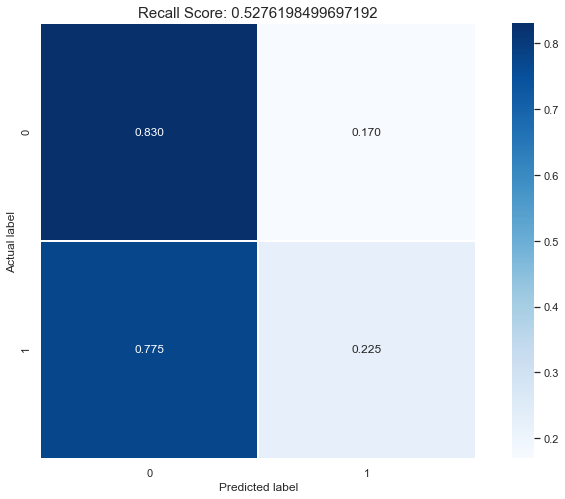

In [78]:
get_model_performance(predictions, 'Blues', X_test, y_test)

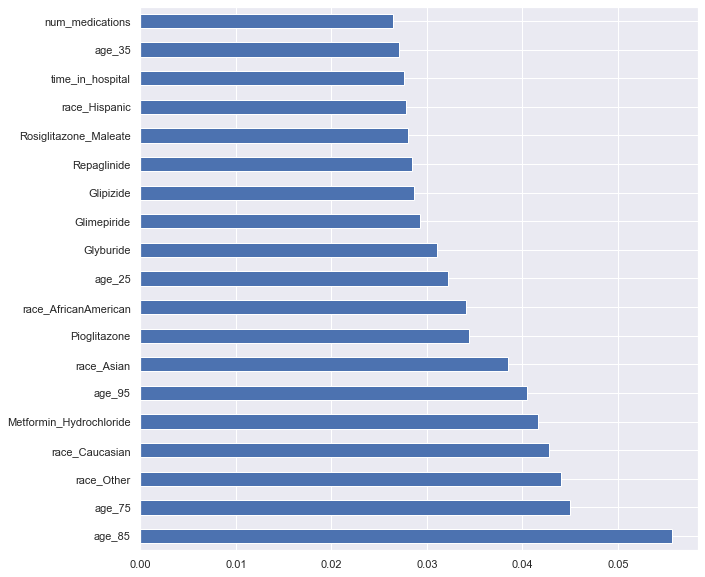

In [79]:
get_important_feats(xgb, X_train)

Confusion Matrix: 
 [[0.58423785 0.41576215]
 [0.56015121 0.43984879]] 

Classification Report: 
                 precision    recall  f1-score   support

Not Readmitted       0.60      0.58      0.59      6357
    Readmitted       0.43      0.44      0.43      4497

      accuracy                           0.52     10854
     macro avg       0.51      0.51      0.51     10854
  weighted avg       0.53      0.52      0.53     10854
 

True Negative: 0.584237848041529
False Positive: 0.415762151958471
False Negative: 0.5601512119190571
True Positive: 0.43984878808094285 

Precision score: 0.5119533093658986
Recall score: 0.5120433180612359
F1 score : 0.5119295666507137
Accuracy score: 0.5244149622259076


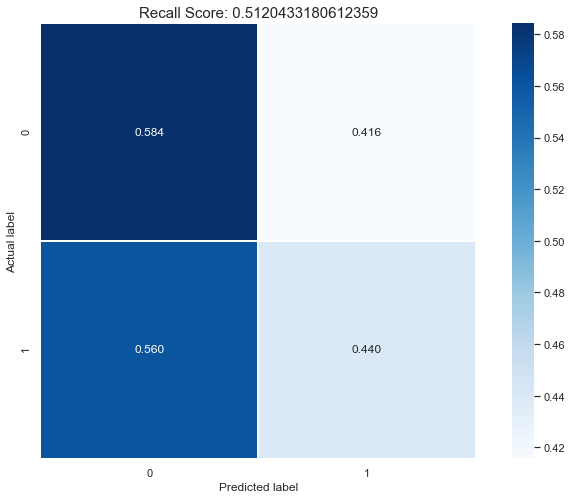

In [80]:
predictions, score = model_test(decision, X_train, y_train, 
                                X_test, y_test)
get_model_performance(predictions, 'Blues', X_test, y_test)



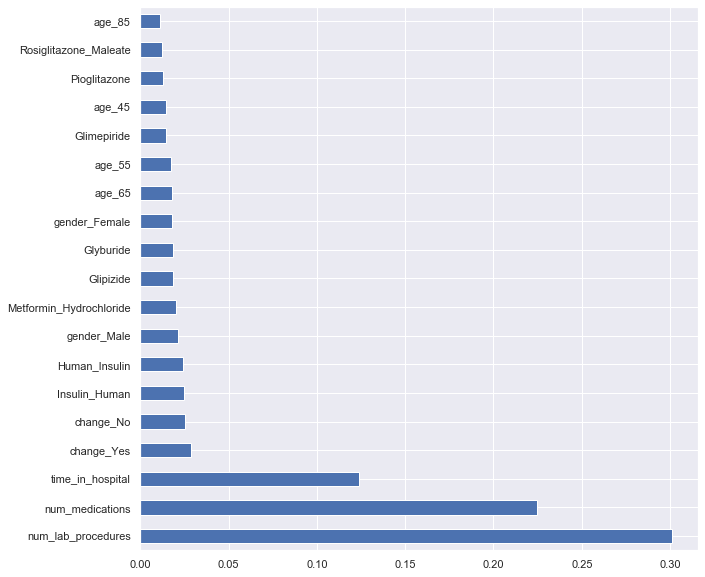

In [81]:
get_important_feats(decision, X_train)

Confusion Matrix: 
 [[0.95154947 0.04845053]
 [0.92483878 0.07516122]] 

Classification Report: 
                 precision    recall  f1-score   support

Not Readmitted       0.59      0.95      0.73      6357
    Readmitted       0.52      0.08      0.13      4497

      accuracy                           0.59     10854
     macro avg       0.56      0.51      0.43     10854
  weighted avg       0.56      0.59      0.48     10854
 

True Negative: 0.9515494730218657
False Positive: 0.04845052697813434
False Negative: 0.9248387814098288
True Positive: 0.07516121859017122 

Precision score: 0.5578971328260722
Recall score: 0.5133553458060185
F1 score : 0.4308879185391377
Accuracy score: 0.5884466556108348


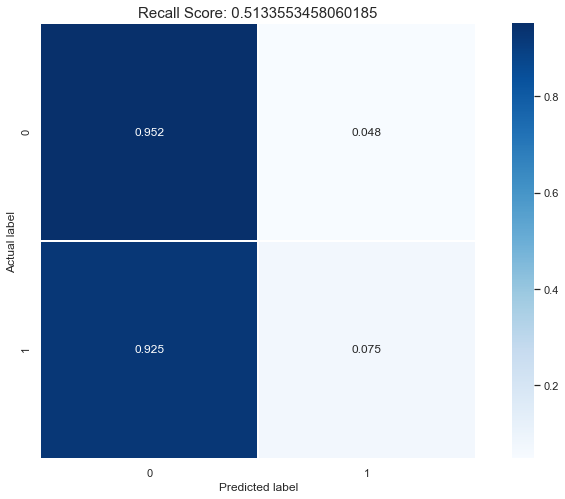

In [82]:
predictions, score = model_test(gbc, X_train, y_train, 
                                X_test, y_test)
get_model_performance(predictions, 'Blues', X_test, y_test)

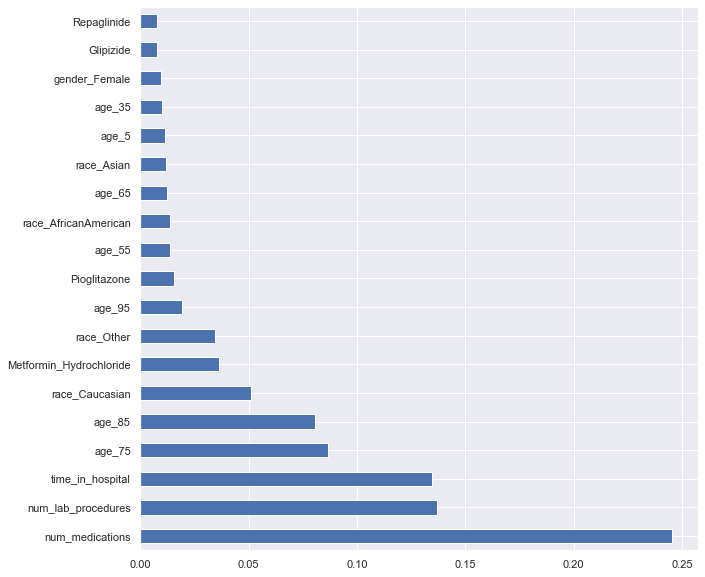

In [83]:
get_important_feats(gbc, X_train)

Confusion Matrix: 
 [[0.66021708 0.33978292]
 [0.60796086 0.39203914]] 

Classification Report: 
                 precision    recall  f1-score   support

Not Readmitted       0.61      0.66      0.63      6357
    Readmitted       0.45      0.39      0.42      4497

      accuracy                           0.55     10854
     macro avg       0.53      0.53      0.53     10854
  weighted avg       0.54      0.55      0.54     10854
 

True Negative: 0.660217083529967
False Positive: 0.33978291647003306
False Negative: 0.6079608627974205
True Positive: 0.3920391372025795 

Precision score: 0.527470647358859
Recall score: 0.5261281103662733
F1 score : 0.525231309015975
Accuracy score: 0.5491063202505989


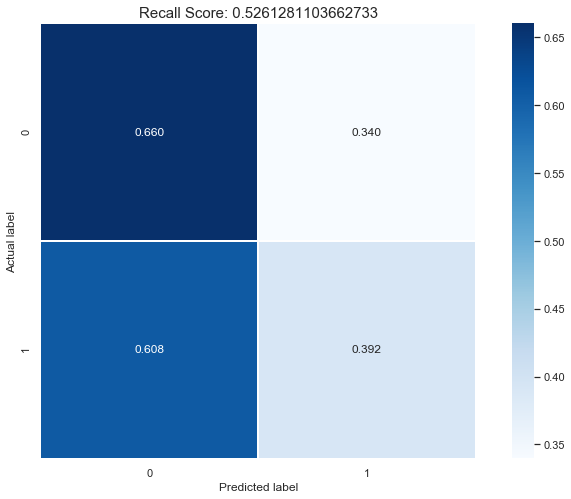

In [84]:
predictions, score = model_test(knn, X_train, y_train, 
                                X_test, y_test)
get_model_performance(predictions, 'Blues', X_test, y_test)

# get_important_feats(knn, X_train)

Confusion Matrix: 
 [[0.70316187 0.29683813]
 [0.64620858 0.35379142]] 

Classification Report: 
                 precision    recall  f1-score   support

Not Readmitted       0.61      0.70      0.65      6357
    Readmitted       0.46      0.35      0.40      4497

      accuracy                           0.56     10854
     macro avg       0.53      0.53      0.52     10854
  weighted avg       0.54      0.56      0.55     10854
 

True Negative: 0.7031618688060406
False Positive: 0.2968381311939594
False Negative: 0.6462085835001112
True Positive: 0.3537914164998888 

Precision score: 0.5317331656436055
Recall score: 0.5284766426529647
F1 score : 0.5249917698188037
Accuracy score: 0.558411645476322


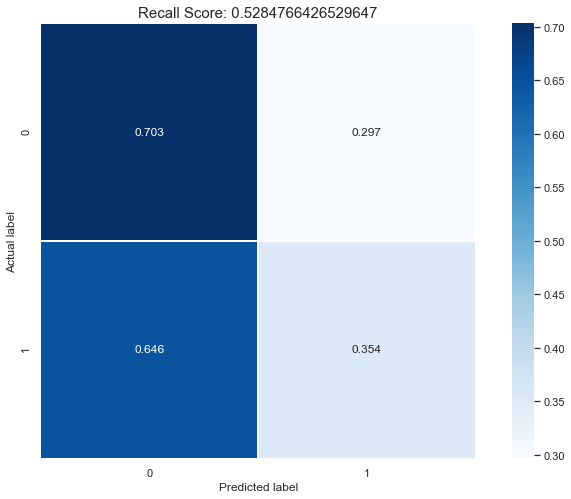

In [85]:
predictions, score = model_test(forest, X_train, y_train, 
                                X_test, y_test)
get_model_performance(predictions, 'Blues', X_test, y_test)

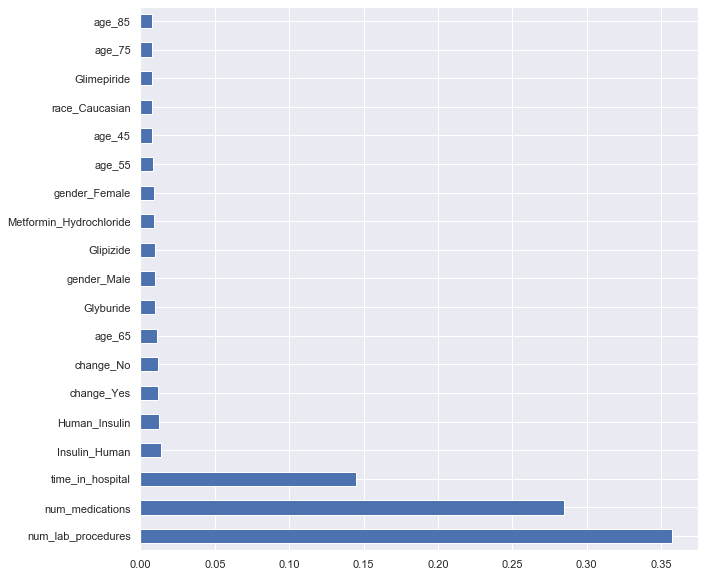

In [86]:
get_important_feats(forest, X_train)

In [90]:
feats_df.num_lab_procedures.unique()

array([ 68,  33,  51,  47,  31,  62,  60,  55,  70,  49,  73,  11,  75,
        45,  29,  35,  42,  59,  66,  36,  19,  64,  25,  53,  52,  87,
        27,  37,  46,  41,  44,  28,  48,  72,  10,   2,  65,  67,  54,
        58,  57,  43,  32,  83,  34,  39,  69,  56,  22,  96,  78,  61,
        88,  50,   1,  18,   9,  71,  63,  77,  81,  76,  90,  93,   3,
       103,  80,  85,  38,  15,  12,  30,  24,  23,  17,  21,  79,  26,
        95,  97,  84,  14,  74,  13,  40, 105,  98,  86,  20,   5,   6,
         8, 100,  89,  94,  82,  91,   7,  92,   4,  16, 101, 102, 114,
       111, 107, 108, 106, 104,  99, 120, 113, 109, 132, 121])

In [91]:
feats_df.num_medications.unique()

array([28, 18,  8, 17, 16, 11, 15, 31, 21,  2, 12, 13, 23, 19,  7, 20, 14,
       10, 22,  9, 27, 25,  4, 32,  6, 30, 26, 24, 33,  5, 39,  3,  1, 29,
       61, 40, 46, 41, 36, 34, 35, 50, 43, 42, 37, 51, 38, 45, 54, 52, 49,
       47, 44, 53, 57, 48, 62, 56, 59, 60, 63, 55, 58, 70, 67, 64, 69, 65,
       66, 68, 81, 79, 75, 72, 74])

In [92]:
X_train.columns

Index(['Acarbose', 'Glimepiride', 'Glipizide', 'Glipizide_And_Metformin_Hcl',
       'Glipizide_And_Metformin_Hydrochloride', 'Glyburide',
       'Glyburide_And_Metformin_Hydrochloride',
       'Glyburide-metformin_Hydrochloride', 'Human_Insulin', 'Insulin_Human',
       'Metformin_Hcl', 'Metformin_Hydrochloride', 'Miglitol', 'Nateglinide',
       'Pioglitazone', 'Pioglitazone_Hydrochloride_And_Glimepiride',
       'Repaglinide', 'Rosiglitazone_Maleate', 'Tolazamide', 'Tolbutamide',
       'num_lab_procedures', 'num_medications', 'time_in_hospital',
       'race_AfricanAmerican', 'race_Asian', 'race_Caucasian', 'race_Hispanic',
       'race_Other', 'gender_Female', 'gender_Male', 'age_5', 'age_15',
       'age_25', 'age_35', 'age_45', 'age_55', 'age_65', 'age_75', 'age_85',
       'age_95', 'change_No', 'change_Yes'],
      dtype='object')

In [93]:
second_round_feats = ['Acarbose', 'Glimepiride', 'Glipizide', 'Glipizide_And_Metformin_Hcl',
       'Glipizide_And_Metformin_Hydrochloride', 'Glyburide',
       'Glyburide_And_Metformin_Hydrochloride',
       'Glyburide-metformin_Hydrochloride', 'Human_Insulin', 'Insulin_Human',
       'Metformin_Hcl', 'Metformin_Hydrochloride', 'Miglitol', 'Nateglinide',
       'Pioglitazone', 'Pioglitazone_Hydrochloride_And_Glimepiride',
       'Repaglinide', 'Rosiglitazone_Maleate', 'Tolazamide', 'Tolbutamide',
       'num_lab_procedures', 'num_medications', 'time_in_hospital',
       'gender_Female', 'gender_Male', 'age_5', 'age_15',
       'age_25', 'age_35', 'age_45', 'age_55', 'age_65', 'age_75', 'age_85',
       'age_95']

In [97]:
xgb = XGBClassifier()
decision = DecisionTreeClassifier(class_weight='balanced')
gbc = GradientBoostingClassifier()
knn = KNeighborsClassifier()
forest = RandomForestClassifier(class_weight='balanced')

In [98]:
X_train2 = X_train[second_round_feats]
X_test2 = X_test[second_round_feats]

[19:11:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Confusion Matrix: 
 [[0.84300771 0.15699229]
 [0.80053369 0.19946631]] 

Classification Report: 
                 precision    recall  f1-score   support

Not Readmitted       0.60      0.84      0.70      6357
    Readmitted       0.47      0.20      0.28      4497

      accuracy                           0.58     10854
     macro avg       0.54      0.52      0.49     10854
  weighted avg       0.55      0.58      0.53     10854
 

True Negative: 0.8430077080383829
False Positive: 0.15699229196161713
False Negative: 0.800533689126084
True Positive: 0.19946631087391595 

Precision score: 0.5357601810181298
Recall score: 0.5212370094561494
F1 score : 0.4902271986627317
Accuracy score: 0.5763773723972729


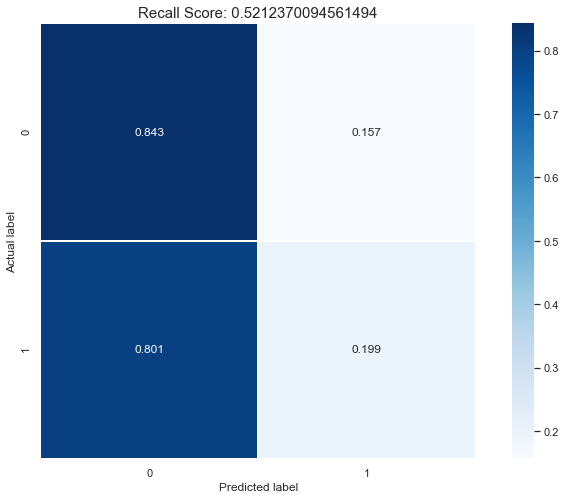

In [99]:
predictions, score = model_test(xgb, X_train2, y_train, 
                                X_test2, y_test)
get_model_performance(predictions, 'Blues', X_test, y_test)



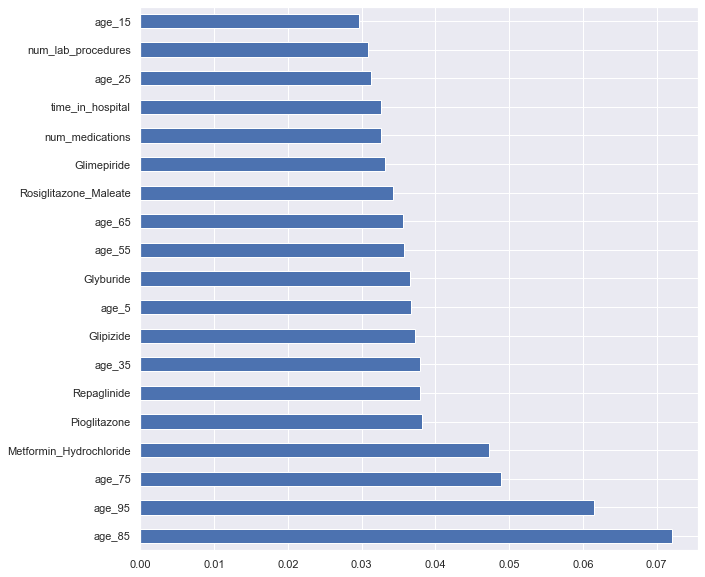

In [101]:
get_important_feats(xgb, X_train2)

Confusion Matrix: 
 [[0.56992292 0.43007708]
 [0.54881032 0.45118968]] 

Classification Report: 
                 precision    recall  f1-score   support

Not Readmitted       0.59      0.57      0.58      6357
    Readmitted       0.43      0.45      0.44      4497

      accuracy                           0.52     10854
     macro avg       0.51      0.51      0.51     10854
  weighted avg       0.52      0.52      0.52     10854
 

True Negative: 0.5699229196161711
False Positive: 0.43007708038382886
False Negative: 0.548810317989771
True Positive: 0.451189682010229 

Precision score: 0.5104020197830283
Recall score: 0.5105563008132001
F1 score : 0.5101652420505588
Accuracy score: 0.5207296849087893


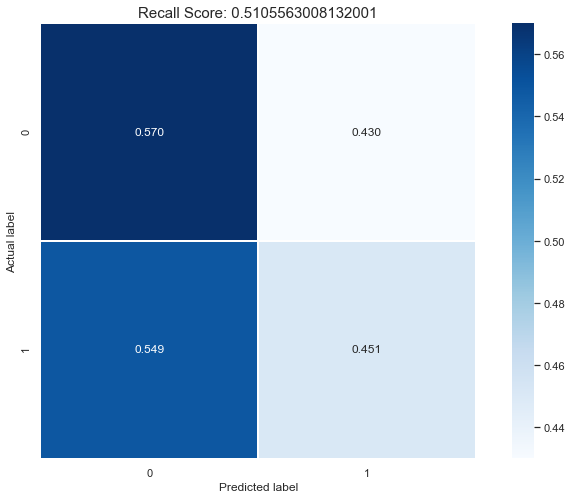

In [103]:
predictions, score = model_test(decision, X_train2, y_train, 
                                X_test2, y_test)
get_model_performance(predictions, 'Blues', X_test2, y_test)



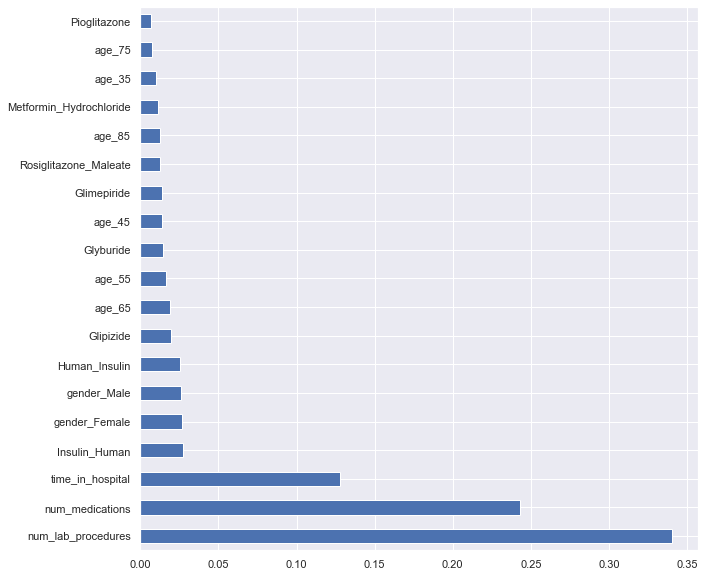

In [104]:
get_important_feats(decision, X_train2)

Confusion Matrix: 
 [[0.95705521 0.04294479]
 [0.9359573  0.0640427 ]] 

Classification Report: 
                 precision    recall  f1-score   support

Not Readmitted       0.59      0.96      0.73      6357
    Readmitted       0.51      0.06      0.11      4497

      accuracy                           0.59     10854
     macro avg       0.55      0.51      0.42     10854
  weighted avg       0.56      0.59      0.48     10854
 

True Negative: 0.9570552147239264
False Positive: 0.04294478527607362
False Negative: 0.9359573048699132
True Positive: 0.06404269513008673 

Precision score: 0.552225150678697
Recall score: 0.5105489549270066
F1 score : 0.42234490718476486
Accuracy score: 0.5870646766169154


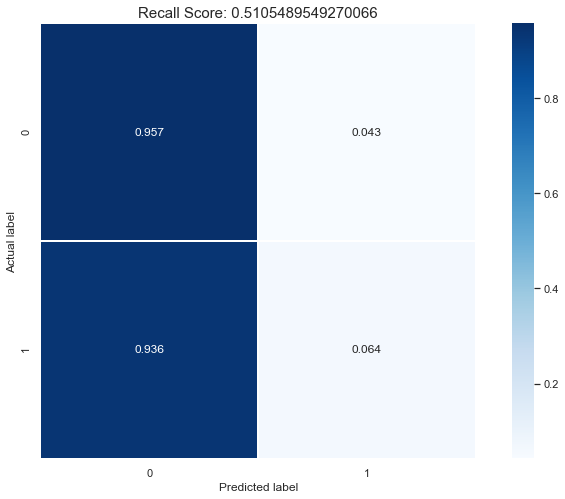

In [105]:
predictions, score = model_test(gbc, X_train2, y_train, 
                                X_test2, y_test)
get_model_performance(predictions, 'Blues', X_test, y_test)

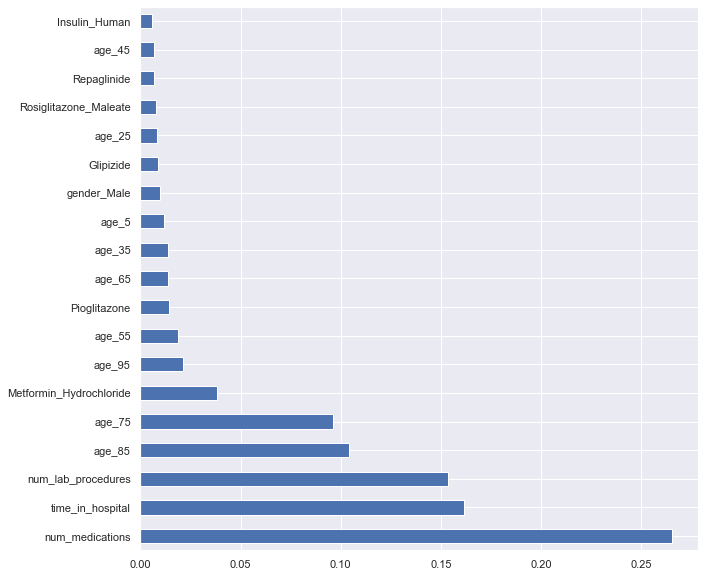

In [107]:
get_important_feats(gbc, X_train2)

Confusion Matrix: 
 [[0.65895863 0.34104137]
 [0.61996887 0.38003113]] 

Classification Report: 
                 precision    recall  f1-score   support

Not Readmitted       0.60      0.66      0.63      6357
    Readmitted       0.44      0.38      0.41      4497

      accuracy                           0.54     10854
     macro avg       0.52      0.52      0.52     10854
  weighted avg       0.53      0.54      0.54     10854
 

True Negative: 0.6589586282837817
False Positive: 0.34104137171621834
False Negative: 0.6199688681343117
True Positive: 0.3800311318656882 

Precision score: 0.520603032277949
Recall score: 0.519494880074735
F1 score : 0.5182433617750686
Accuracy score: 0.5433941404090658


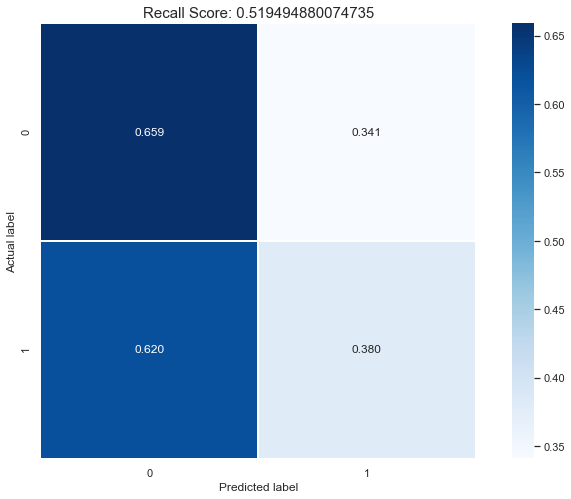

In [108]:
predictions, score = model_test(knn, X_train2, y_train, 
                                X_test2, y_test)
get_model_performance(predictions, 'Blues', X_test2, y_test)

# get_important_feats(knn, X_train)

Confusion Matrix: 
 [[0.66430706 0.33569294]
 [0.6257505  0.3742495 ]] 

Classification Report: 
                 precision    recall  f1-score   support

Not Readmitted       0.60      0.66      0.63      6357
    Readmitted       0.44      0.37      0.40      4497

      accuracy                           0.54     10854
     macro avg       0.52      0.52      0.52     10854
  weighted avg       0.53      0.54      0.54     10854
 

True Negative: 0.6643070630800693
False Positive: 0.3356929369199308
False Negative: 0.6257505003335557
True Positive: 0.3742494996664443 

Precision score: 0.5205179375052983
Recall score: 0.5192782813732568
F1 score : 0.517720065307374
Accuracy score: 0.5441311958724894


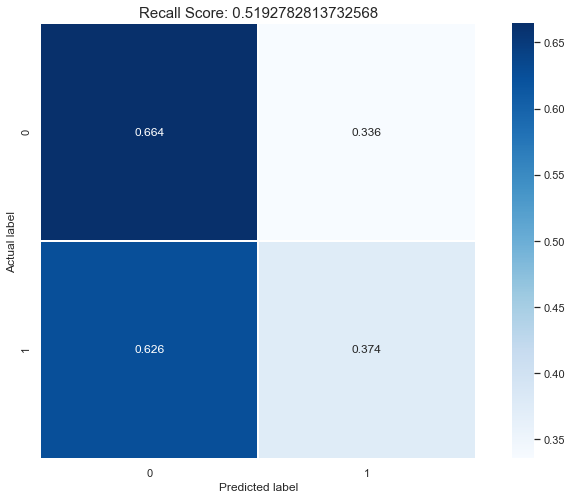

In [109]:
predictions, score = model_test(forest, X_train2, y_train, 
                                X_test2, y_test)
get_model_performance(predictions, 'Blues', X_test2, y_test)

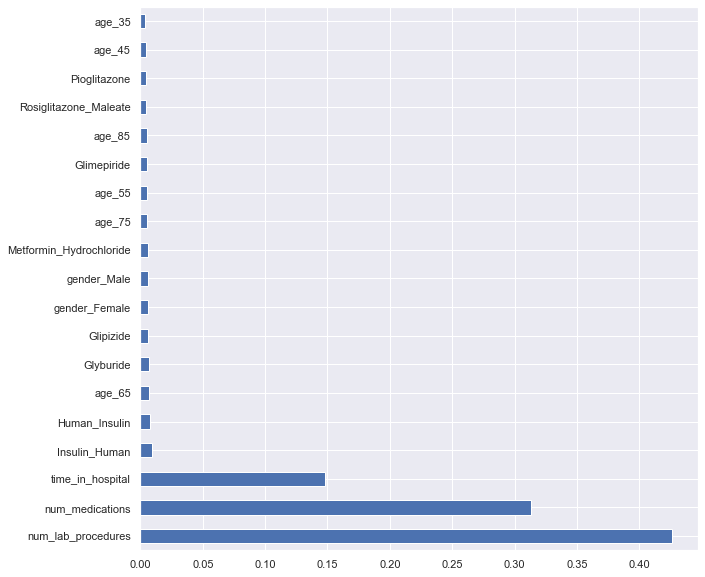

In [110]:
get_important_feats(forest, X_train2)

In [111]:
X_train2.columns

Index(['Acarbose', 'Glimepiride', 'Glipizide', 'Glipizide_And_Metformin_Hcl',
       'Glipizide_And_Metformin_Hydrochloride', 'Glyburide',
       'Glyburide_And_Metformin_Hydrochloride',
       'Glyburide-metformin_Hydrochloride', 'Human_Insulin', 'Insulin_Human',
       'Metformin_Hcl', 'Metformin_Hydrochloride', 'Miglitol', 'Nateglinide',
       'Pioglitazone', 'Pioglitazone_Hydrochloride_And_Glimepiride',
       'Repaglinide', 'Rosiglitazone_Maleate', 'Tolazamide', 'Tolbutamide',
       'num_lab_procedures', 'num_medications', 'time_in_hospital',
       'gender_Female', 'gender_Male', 'age_5', 'age_15', 'age_25', 'age_35',
       'age_45', 'age_55', 'age_65', 'age_75', 'age_85', 'age_95'],
      dtype='object')

In [112]:
third_round = ['num_lab_procedures', 'num_medications', 'time_in_hospital',
       'gender_Female', 'gender_Male',
       'age_45', 'age_55', 'age_65', 'age_75', 'age_85', 'age_95']

In [113]:
X_train3 = X_train2[third_round]
X_test3 = X_test2[third_round]

In [114]:
xgb = XGBClassifier()
decision = DecisionTreeClassifier(class_weight='balanced')
gbc = GradientBoostingClassifier()
knn = KNeighborsClassifier()
forest = RandomForestClassifier(class_weight='balanced')

[19:19:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Confusion Matrix: 
 [[0.83341199 0.16658801]
 [0.79186124 0.20813876]] 

Classification Report: 
                 precision    recall  f1-score   support

Not Readmitted       0.60      0.83      0.70      6357
    Readmitted       0.47      0.21      0.29      4497

      accuracy                           0.57     10854
     macro avg       0.53      0.52      0.49     10854
  weighted avg       0.54      0.57      0.53     10854
 

True Negative: 0.8334119867862199
False Positive: 0.16658801321378008
False Negative: 0.7918612408272181
True Positive: 0.20813875917278185 

Precision score: 0.533604414015058
Recall score: 0.5207753729795008
F1 score : 0.49236356904202405
Accuracy score: 0.574350469872858


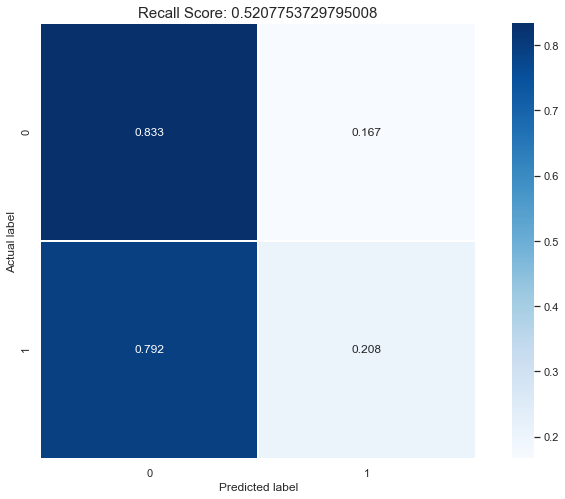

In [115]:
predictions, score = model_test(xgb, X_train3, y_train, 
                                X_test3, y_test)
get_model_performance(predictions, 'Blues', X_test3, y_test)


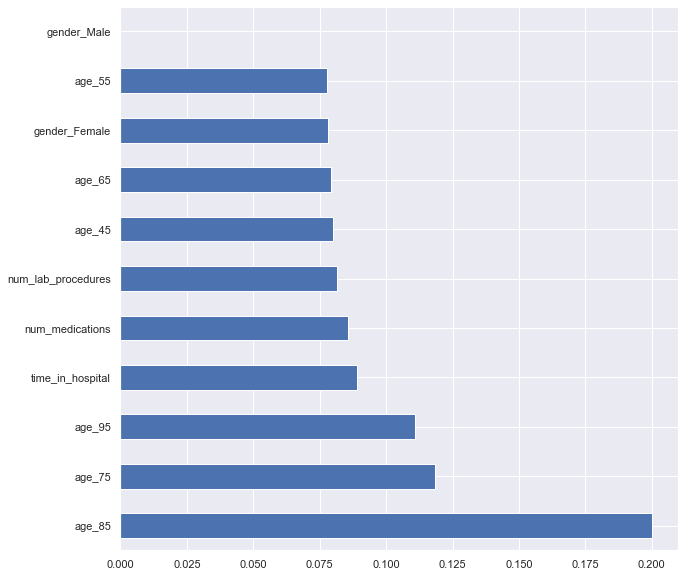

In [116]:
get_important_feats(xgb, X_train3)

Confusion Matrix: 
 [[0.56960831 0.43039169]
 [0.53969313 0.46030687]] 

Classification Report: 
                 precision    recall  f1-score   support

Not Readmitted       0.60      0.57      0.58      6357
    Readmitted       0.43      0.46      0.45      4497

      accuracy                           0.52     10854
     macro avg       0.51      0.51      0.51     10854
  weighted avg       0.53      0.52      0.53     10854
 

True Negative: 0.5696083058046248
False Positive: 0.43039169419537515
False Negative: 0.5396931287525016
True Positive: 0.4603068712474983 

Precision score: 0.5147109639736044
Recall score: 0.5149575885260615
F1 score : 0.5144072961602666
Accuracy score: 0.5243228302929795


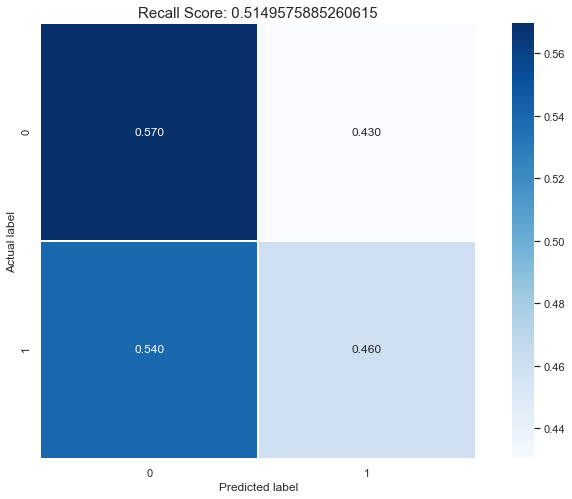

In [117]:
predictions, score = model_test(decision, X_train3, y_train, 
                                X_test3, y_test)
get_model_performance(predictions, 'Blues', X_test3, y_test)


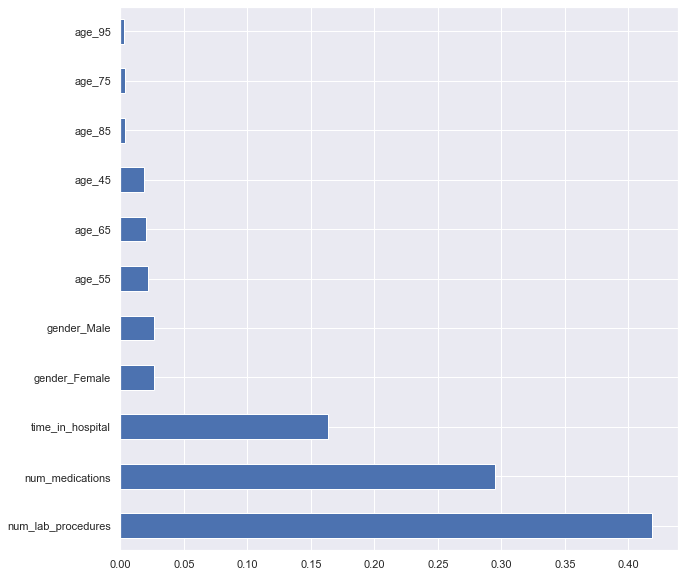

In [118]:
get_important_feats(decision, X_train3)

Confusion Matrix: 
 [[0.95941482 0.04058518]
 [0.94574161 0.05425839]] 

Classification Report: 
                 precision    recall  f1-score   support

Not Readmitted       0.59      0.96      0.73      6357
    Readmitted       0.49      0.05      0.10      4497

      accuracy                           0.58     10854
     macro avg       0.54      0.51      0.41     10854
  weighted avg       0.55      0.58      0.47     10854
 

True Negative: 0.9594148183105239
False Positive: 0.04058518168947617
False Negative: 0.9457416055147876
True Positive: 0.054258394485212365 

Precision score: 0.5376086457877917
Recall score: 0.5068366063978681
F1 score : 0.4138226292694053
Accuracy score: 0.5843928505620047


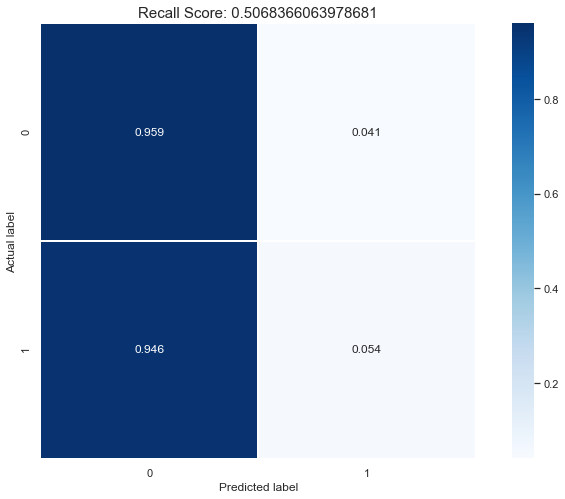

In [119]:
predictions, score = model_test(gbc, X_train3, y_train, 
                                X_test3, y_test)
get_model_performance(predictions, 'Blues', X_test3, y_test)


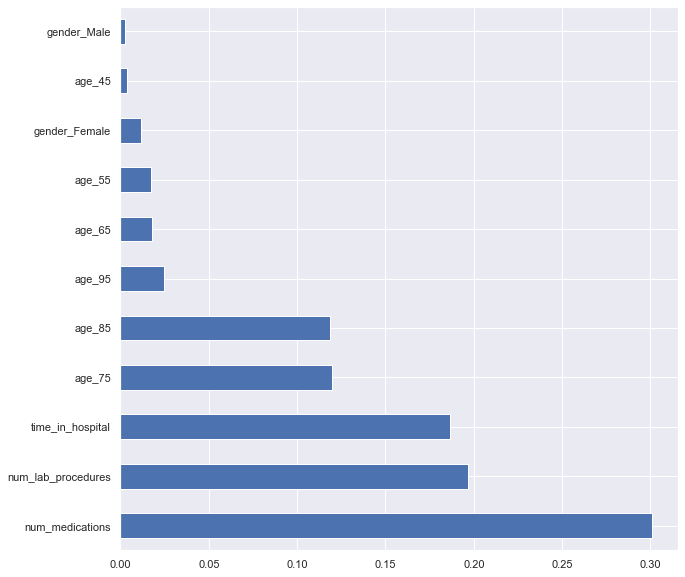

In [120]:
get_important_feats(gbc, X_train3)

Confusion Matrix: 
 [[0.6537675 0.3462325]
 [0.6355348 0.3644652]] 

Classification Report: 
                 precision    recall  f1-score   support

Not Readmitted       0.59      0.65      0.62      6357
    Readmitted       0.43      0.36      0.39      4497

      accuracy                           0.53     10854
     macro avg       0.51      0.51      0.51     10854
  weighted avg       0.52      0.53      0.53     10854
 

True Negative: 0.6537675003932673
False Positive: 0.34623249960673275
False Negative: 0.6355348009784301
True Positive: 0.36446519902156993 

Precision score: 0.5096760719632164
Recall score: 0.5091163497074186
F1 score : 0.507415426913751
Accuracy score: 0.5339045513174866


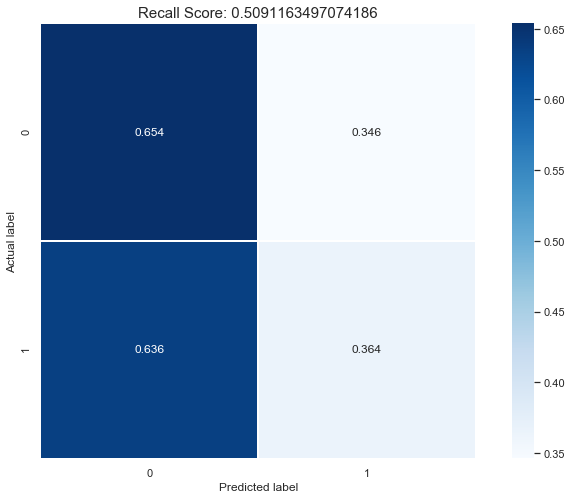

In [121]:
predictions, score = model_test(knn, X_train3, y_train, 
                                X_test3, y_test)
get_model_performance(predictions, 'Blues', X_test3, y_test)
# get_important_feats(knn, X_train3)

Confusion Matrix: 
 [[0.63174453 0.36825547]
 [0.61352012 0.38647988]] 

Classification Report: 
                 precision    recall  f1-score   support

Not Readmitted       0.59      0.63      0.61      6357
    Readmitted       0.43      0.39      0.41      4497

      accuracy                           0.53     10854
     macro avg       0.51      0.51      0.51     10854
  weighted avg       0.52      0.53      0.53     10854
 

True Negative: 0.6317445335850244
False Positive: 0.36825546641497564
False Negative: 0.6135201245274627
True Positive: 0.38647987547253726 

Precision score: 0.509426176193608
Recall score: 0.5091122045287808
F1 score : 0.5084764316174231
Accuracy score: 0.5301271420674406


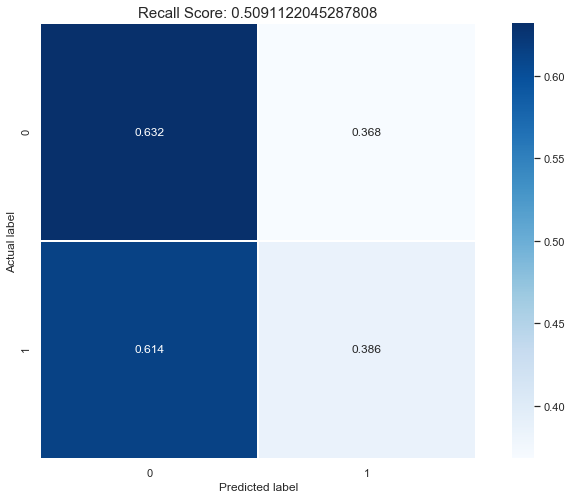

In [122]:
predictions, score = model_test(forest, X_train3, y_train, 
                                X_test3, y_test)
get_model_performance(predictions, 'Blues', X_test3, y_test)


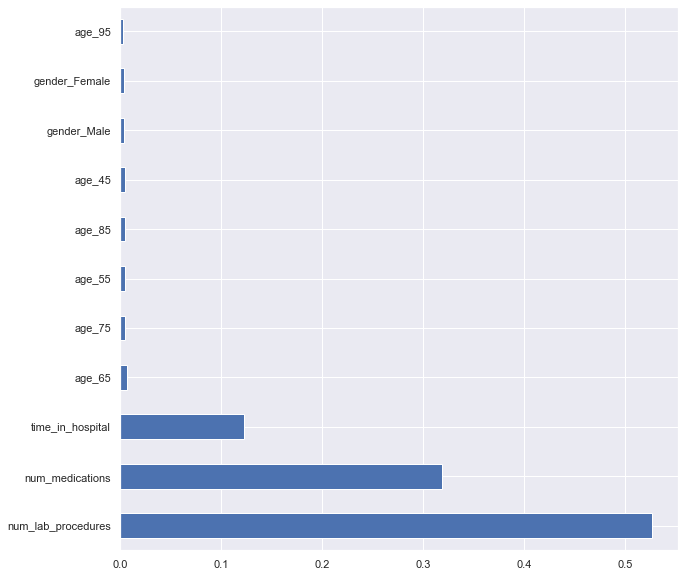

In [123]:
get_important_feats(forest, X_train3)